# Hub Passenger Flow Prediction

# 1 Check Environment

## 1.1 Python Version
python 3 on anaconda

In [1]:
!python3 --version

Python 3.7.5


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [3]:
import tensorflow
import keras
print('tensorflow:', tensorflow.__version__)
print('keras:', keras.__version__)
!python3 --version

tensorflow: 2.0.0
keras: 2.3.1
Python 3.7.5


Using TensorFlow backend.


In [4]:
import numpy
print('numpy:', numpy.__version__)
import scipy
print("scipy:", scipy.__version__)
#import matplotlib as plt
#print('matplotlib:', matplotlib.__version__)


numpy: 1.17.3
scipy: 1.2.1


# 2 Data Processing

In [5]:
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
import numpy as np
import csv
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import metrics

In [6]:
# 把日期hash计算:"2018/1/1 0:00:26"--> 0=2018010100
# date 指标： 反映时间的变化
# >> date:"20180101" hour:"00"
def transfer_time(str):
    # str: "2018/1/1 0:00:26"
    data = str.split(' ')
    if len(data) == 1:
        date = data[0]
        hour = 0
        #pdb.set_trace()
    else:
        date = data[0]
        hour = data[1]
    try:
        temp_date = date.split('/')
        if len(temp_date[1]) == 1:
            temp_date[1] = '0' + temp_date[1]
        if len(temp_date[2]) == 1:
            temp_date[2] = '0' + temp_date[2]
        date = temp_date[0] + temp_date[1] + temp_date[2]
        temp_hour = hour.split(':')
        hour = temp_hour[0]
        if len(hour) < 2:
            hour = '0' + hour
    # return 日期和时段
    except Exception as e:
        print("Transfer to time exception:",date)
        print(e)
        hour = "00"
    return date, hour

## 2.1 Read Data

In [7]:
# 读取data
# (train_data, train_target), (test_data, test_target) 获取
"""
csv_data: passenger flow
"""
csv_data = pd.read_csv('data.csv')

In [8]:
# data: {datehour: {t},wind, holiday, weather, datehour, hum, week}
with open('data.json', 'r') as f:
    json_data = json.load(f)

In [9]:
json_data

{'2018010105': {'t': '2℃',
  'hum': '91%',
  'weather': '晴',
  'wind': '1级',
  'holiday': 1,
  'week': 1,
  'date': 2018010105},
 '2018010106': {'t': '2℃',
  'hum': '91%',
  'weather': '晴',
  'wind': '1级',
  'holiday': 1,
  'week': 1,
  'date': 2018010106},
 '2018010107': {'t': '2℃',
  'hum': '94%',
  'weather': '晴',
  'wind': '0级',
  'holiday': 1,
  'week': 1,
  'date': 2018010107},
 '2018010108': {'t': '5℃',
  'hum': '76%',
  'weather': '晴',
  'wind': '1级',
  'holiday': 1,
  'week': 1,
  'date': 2018010108},
 '2018010109': {'t': '7℃',
  'hum': '56%',
  'weather': '晴',
  'wind': '2级',
  'holiday': 1,
  'week': 1,
  'date': 2018010109},
 '2018010110': {'t': '9℃',
  'hum': '36%',
  'weather': '晴',
  'wind': '2级',
  'holiday': 1,
  'week': 1,
  'date': 2018010110},
 '2018010111': {'t': '10℃',
  'hum': '34%',
  'weather': '晴',
  'wind': '1级',
  'holiday': 1,
  'week': 1,
  'date': 2018010111},
 '2018010112': {'t': '10℃',
  'hum': '24%',
  'weather': '晴',
  'wind': '1级',
  'holiday': 1,
  

In [10]:
# 看是否存在缺失值
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65538 entries, 0 to 65537
Data columns (total 7 columns):
ID                  65538 non-null int64
W_C_AREA_CODE       65538 non-null object
TJ_TIME             65538 non-null object
IN_TOTAL            65538 non-null int64
OUT_TOTAL           65538 non-null int64
REMARK              65538 non-null int64
W_M_WAYKIND_NAME    65538 non-null object
dtypes: int64(4), object(3)
memory usage: 3.5+ MB


In [11]:
# 将数据整理成date -> data 的字典
# dataFrame: read data 2018/01/01-2018/04/25
csv_batch_data = csv_data
# values dataFrame->array  Transfer array data to dictionary:
print('csv_data shape:', csv_batch_data.shape)
# train_batch_data = csv_batch_data[list(range(3, 6))]  取3:5列
# dataFrame 取行
train_batch_data = csv_batch_data[1:]
#  按照机器类型，将数据分为两组
# 314684 row 之后只有machine1 数据
machine1_data = []
machine2_data = []
# data 为list： ID 0 , W_C_AREA_CODE 1, Time 2, In_total 3, Out_total 4.  DataFrame.values -> array
for data in train_batch_data.values:  
    if data[1] == '05-19-10':
        # list of array -> [ID 0 , W_C_AREA_CODE 1, Time 2, In_total 3, Out_total 4]
        machine1_data.append(data)
    elif data[1] == '04-17-03':
        machine2_data.append(data)
    else:
        print("machine type error!")
# Passenger flow =  In_total + Out_total
print('machine1_data shape:', len(machine1_data))
print('machine2_data shape:', len(machine2_data))

csv_data shape: (65538, 7)
machine1_data shape: 32599
machine2_data shape: 32938


## 2.2 Transform Data to Hour Passenger Flow

In [12]:
"""
统计小时划分的客流量数据 > data_set1({datehour:[date,weather,week,holiday,high_tmp,low_tmp,wind]}) and target_set1:{datehour:flow} 
"""
import pdb
# [Time 2, In_total 3, Out_total 4] -> machine_data: [Date 0, hour 1, In_total 3, Out_total 4] 
# data_set and target_set 按照日期-时段为key进行划分
# 小时统计算法：记录第一个点record = record(h0), 遍历，if date-hour not changed, update flow, else: dict[date-h_pre] = flow - record, update record = flow.
data_set1 = {}
data_set2= {}
target_set1 = {}
target_set2 = {}

# print(machine1_data) : [Date 0, hour 1, In_total 3, Out_total 4] 

In [13]:
def get_hour_data(machine1_data, data_set1, target_set1):
    record = 0
    flow = 0
    flag_start = True
    date_start = True
    pre_date = 0
    for i in range(len(machine1_data)):
        machine1_data[i][0], machine1_data[i][1] = transfer_time(machine1_data[i][2])
        in_total = machine1_data[i][3]
        out_total = machine1_data[i][4]
        date = machine1_data[i][0]
        hour = machine1_data[i][1]
        if int(hour)>=0 and int(hour)<=4:
            continue
        if flag_start:
            key_start = date + hour
            flag_start = False
        if date_start:
            pre_date = date
            date_start = False
        key = date + hour #2019010100
        # In the same hour: update flow
        if key == key_start:
            flow = (in_total + out_total)
        else:
        # change to next hour:
            # change to next day: record --> 0
            if date != pre_date:
                pre_date = date
                target_set1[key_start] = flow - record
                data_set1[key_start] = json_data[key_start]   # key_start: pre key
                record = 0
                flow = in_total + out_total
            else:
                target_set1[key_start] = flow - record
                data_set1[key_start] = json_data[key_start]
                record = flow
            key_start = key

In [14]:
get_hour_data(machine1_data, data_set1, target_set1)
get_hour_data(machine2_data, data_set2, target_set2)
print(len(target_set1),len(target_set2))

2184 2184


In [15]:
# Traversal data_set1 and Add Passenger-flow in target_set1 and target_set2 with same date-hour
# Use data_set1 and target_set as Input and Output raw data
target_set = {}
for key in target_set1:
    if key in target_set2:
        target_set[key] = target_set1[key] + target_set2[key]
print(len(target_set))

2184


In [16]:
def plot_week(target_set):
    fig= plt.figure(figsize=(12,5))
    y = []
    x_data = list(target_set.keys())
    x = x_data[19:153]
    for key in x:
        y.append(target_set[key])
    y = np.array(y)
    x_data = np.linspace(0, 135, len(y))
    #x_data = np.array(x_data)
    plt.plot(x_data,y,'b-',lw=1)

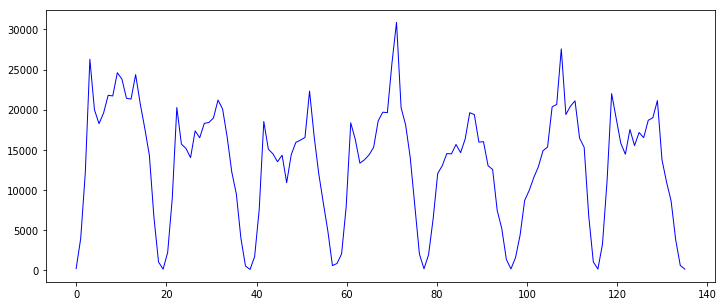

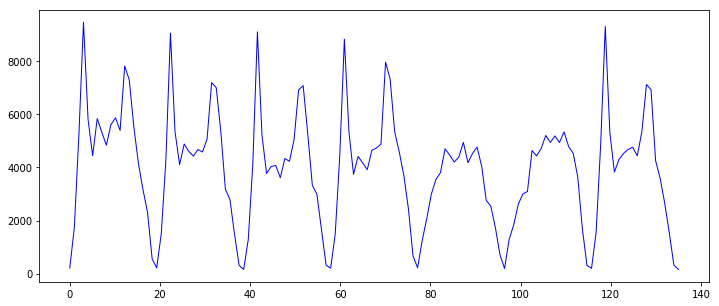

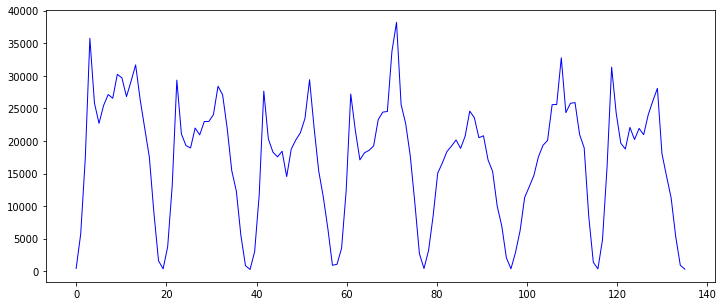

In [17]:
# 输出一天Passenger Flow / h 实际值   --> machine 1
plot_week(target_set1)
plot_week(target_set2)
plot_week(target_set)

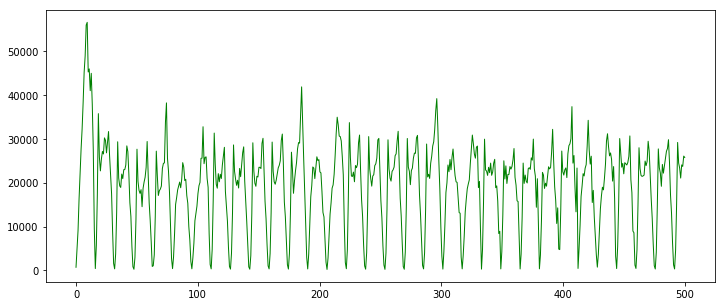

In [18]:
"""
Plot hour_flow figure:
"""
# 输出一天Passenger Flow / h 实际值  --> machine 2
fig= plt.figure(figsize=(12,5))
y = []
x_data = list(target_set.keys())
x = x_data[0:600]
for key in x:
    y.append(target_set[key])
y = np.array(y)
x_data = np.linspace(0, 500, len(y))
#x_data = np.array(x_data)
plt.plot(x_data,y,'g-',lw=1)

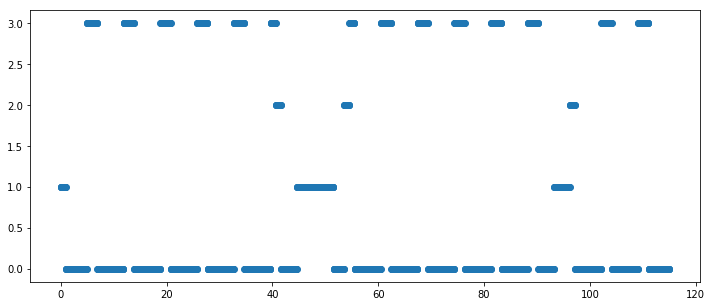

In [19]:
"""
Plot dict_holiday figure: 节假日情况分布 
"week day 0, holiday in law 1, make up for working 2，weekend 3 "
"""
# 输出一天Passenger Flow / h 实际值  --> machine 2
holiday = []
for value in json_data.values():
    holiday.append(value['holiday'])
fig= plt.figure(figsize=(12,5))
y = []
y = holiday
y = np.array(y)
x_data = np.linspace(0, 115, len(y))
#x_data = np.array(x_data)
plt.scatter(x_data,y)

In [20]:
# 两个machine的数据不对称，先放弃machine2， 对machine1的数据进行分析

标准化： $X_t = \frac {X - mean} {std}$
计算客流量累加值为/1 hour 的时段值

In [21]:
data_set1.values()

dict_values([{'t': '2℃', 'hum': '91%', 'weather': '晴', 'wind': '1级', 'holiday': 1, 'week': 1, 'date': 2018010105}, {'t': '2℃', 'hum': '91%', 'weather': '晴', 'wind': '1级', 'holiday': 1, 'week': 1, 'date': 2018010106}, {'t': '2℃', 'hum': '94%', 'weather': '晴', 'wind': '0级', 'holiday': 1, 'week': 1, 'date': 2018010107}, {'t': '5℃', 'hum': '76%', 'weather': '晴', 'wind': '1级', 'holiday': 1, 'week': 1, 'date': 2018010108}, {'t': '7℃', 'hum': '56%', 'weather': '晴', 'wind': '2级', 'holiday': 1, 'week': 1, 'date': 2018010109}, {'t': '9℃', 'hum': '36%', 'weather': '晴', 'wind': '2级', 'holiday': 1, 'week': 1, 'date': 2018010110}, {'t': '10℃', 'hum': '34%', 'weather': '晴', 'wind': '1级', 'holiday': 1, 'week': 1, 'date': 2018010111}, {'t': '10℃', 'hum': '24%', 'weather': '晴', 'wind': '1级', 'holiday': 1, 'week': 1, 'date': 2018010112}, {'t': '11℃', 'hum': '29%', 'weather': '晴', 'wind': '1级', 'holiday': 1, 'week': 1, 'date': 2018010113}, {'t': '11℃', 'hum': '27%', 'weather': '晴', 'wind': '2级', 'holiday'

In [22]:
# data_set{datehour: {t:{int}, hum:{int}, weather:{label_encoder}, wind:{int}, holiday:{int}, week:{int}, date:{int},hour:{int}}}
# target_set{datehour: flow}
# dict_values -> obj -> list -> array
# >> data, target
x = []
dict_x = []
#enc.categories_ [array(['多云', '晴', '阴', '阵雨', '阵雪', '雨夹雪', '雾'], dtype='<U3')]
dict_weather={'晴':0, '多云':1,'阴':2, '雾':3,'阵雪':4,'阵雨':5,'雨夹雪':6}
weather = []
for value in data_set1.values():
    dict_x.append(value)
for value in dict_x:
    x.append(np.array(list(value.values())))
for value in x:
    weather.append(value[2])
weather = np.array(weather)
weather = weather.reshape(-1,1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(weather)
category = enc.categories_
weather = enc.transform(weather).toarray()
for i in range(len(x)):   
    x0 = int(x[i][0][:-1])# wind
    x1 = int(x[i][1][:-1])
    #     category = 0
    #     for j in range(len(weather[i])):
    #         category += j * weather[i][j]
    x2 = dict_weather[x[i][2]]
    x3 = int(x[i][3][:-1])
    x4 = int(x[i][4])
    x5 = int(x[i][5])
    x6 = int(x[i][6])
    x7 = int(x[i][6][-2:])
    x[i] = [x0,x1,x2,x3,x4,x5,x6,x7]
y = list(target_set.values())
data = np.array(x)
target = np.array(y)
mean = data.mean(axis=0)
# pdb.set_trace()
std = data.std(axis = 0)
# 数组中的每一个element都会减mean
data = (data - mean) / std
# target_set = (target_set - mean_y) / std_y

In [23]:
# 两个machine的数据不对称，先放弃machine2， 对machine1的数据进行分析
# >> target and data for input(train:test)
print(data.shape)
print(target.shape)

(2184, 8)
(2184,)


# 3 Target Variable Visualization
Some analysis on target variable

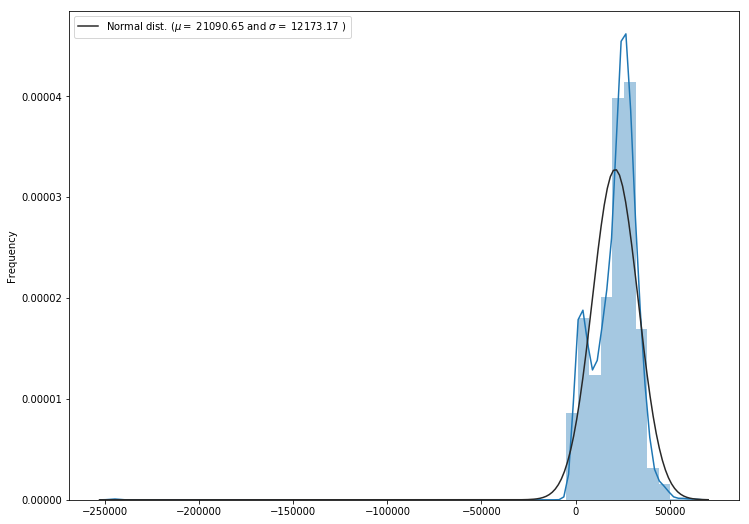

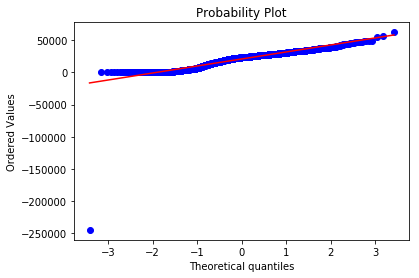

In [24]:
plt.subplots(figsize=(12,9))
sns.distplot(target, fit=stats.norm)

# Get the fitted parameters used by the function

(mu, sigma) = stats.norm.fit(target)

# plot with the distribution

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

#Probablity plot

fig = plt.figure()
stats.probplot(target, plot=plt)
plt.show()

#### Here we use log for target variable to make more normal distribution

In [25]:
# input: data  Output: target

In [26]:
def build_model():
    model = Sequential()
    # 先将维度放大， 在高维空间中抽取特征  
    # Input: week, hour, date, weather
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))    
    model.add(Dense(1))
    # 输出偏差矩阵 correspond to train_target
    model.compile(optimizer = RMSprop(), loss="mse", metrics=['mae'])
    return model

In [27]:
for i in range(len(target)):
    if target[i]<0:
        target[i] = 0

In [28]:
train_size = int(len(target) * 0.9)
train_data = data[ : train_size]
#print(train_data)
train_target = target[ : train_size]
test_data = data[train_size : ]
test_target = target[train_size : ]
print(len(train_data),len(test_data))

1965 219


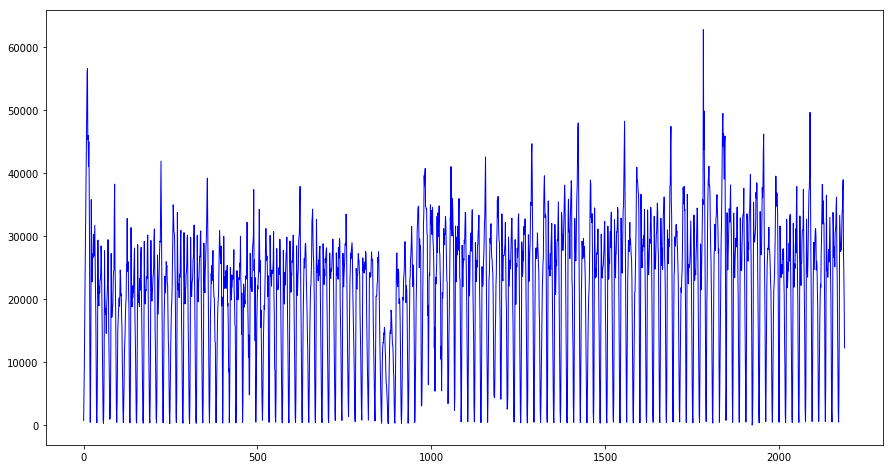

In [29]:
plt.figure(figsize=(15,8))    
x = np.linspace(0,2189,len(target))
plt.plot(x,target,'b-',lw=1)

# Correlation Analysis
select features with correlation over 0.5

In [30]:
# t:{int}, hum:{int}, weather:{label_encoder}, wind:{int}, holiday:{int}, week:{int}, date:{int}
train = pd.DataFrame(np.c_[train_data,train_target],columns=['t','hum','weather','wind','holiday','week','date','hour','target'])

train.columns[train.isnull().any()]

Index([], dtype='object')

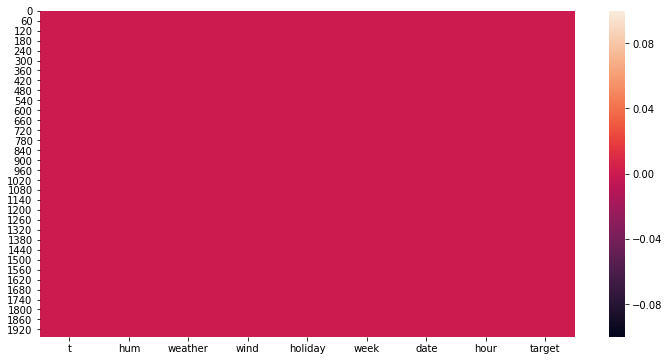

In [31]:
plt.figure(figsize=(12,6))
sns.heatmap(train.isnull())
plt.show()

In [32]:
train_corr = train.select_dtypes(include = [np.number])
train_corr.shape

(1965, 9)

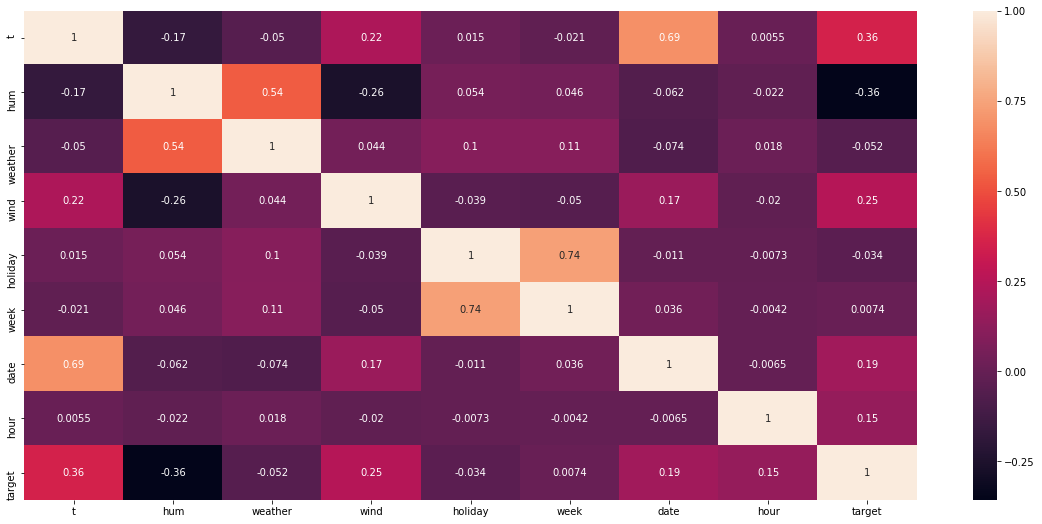

In [33]:
corr = train_corr.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr,annot=True)

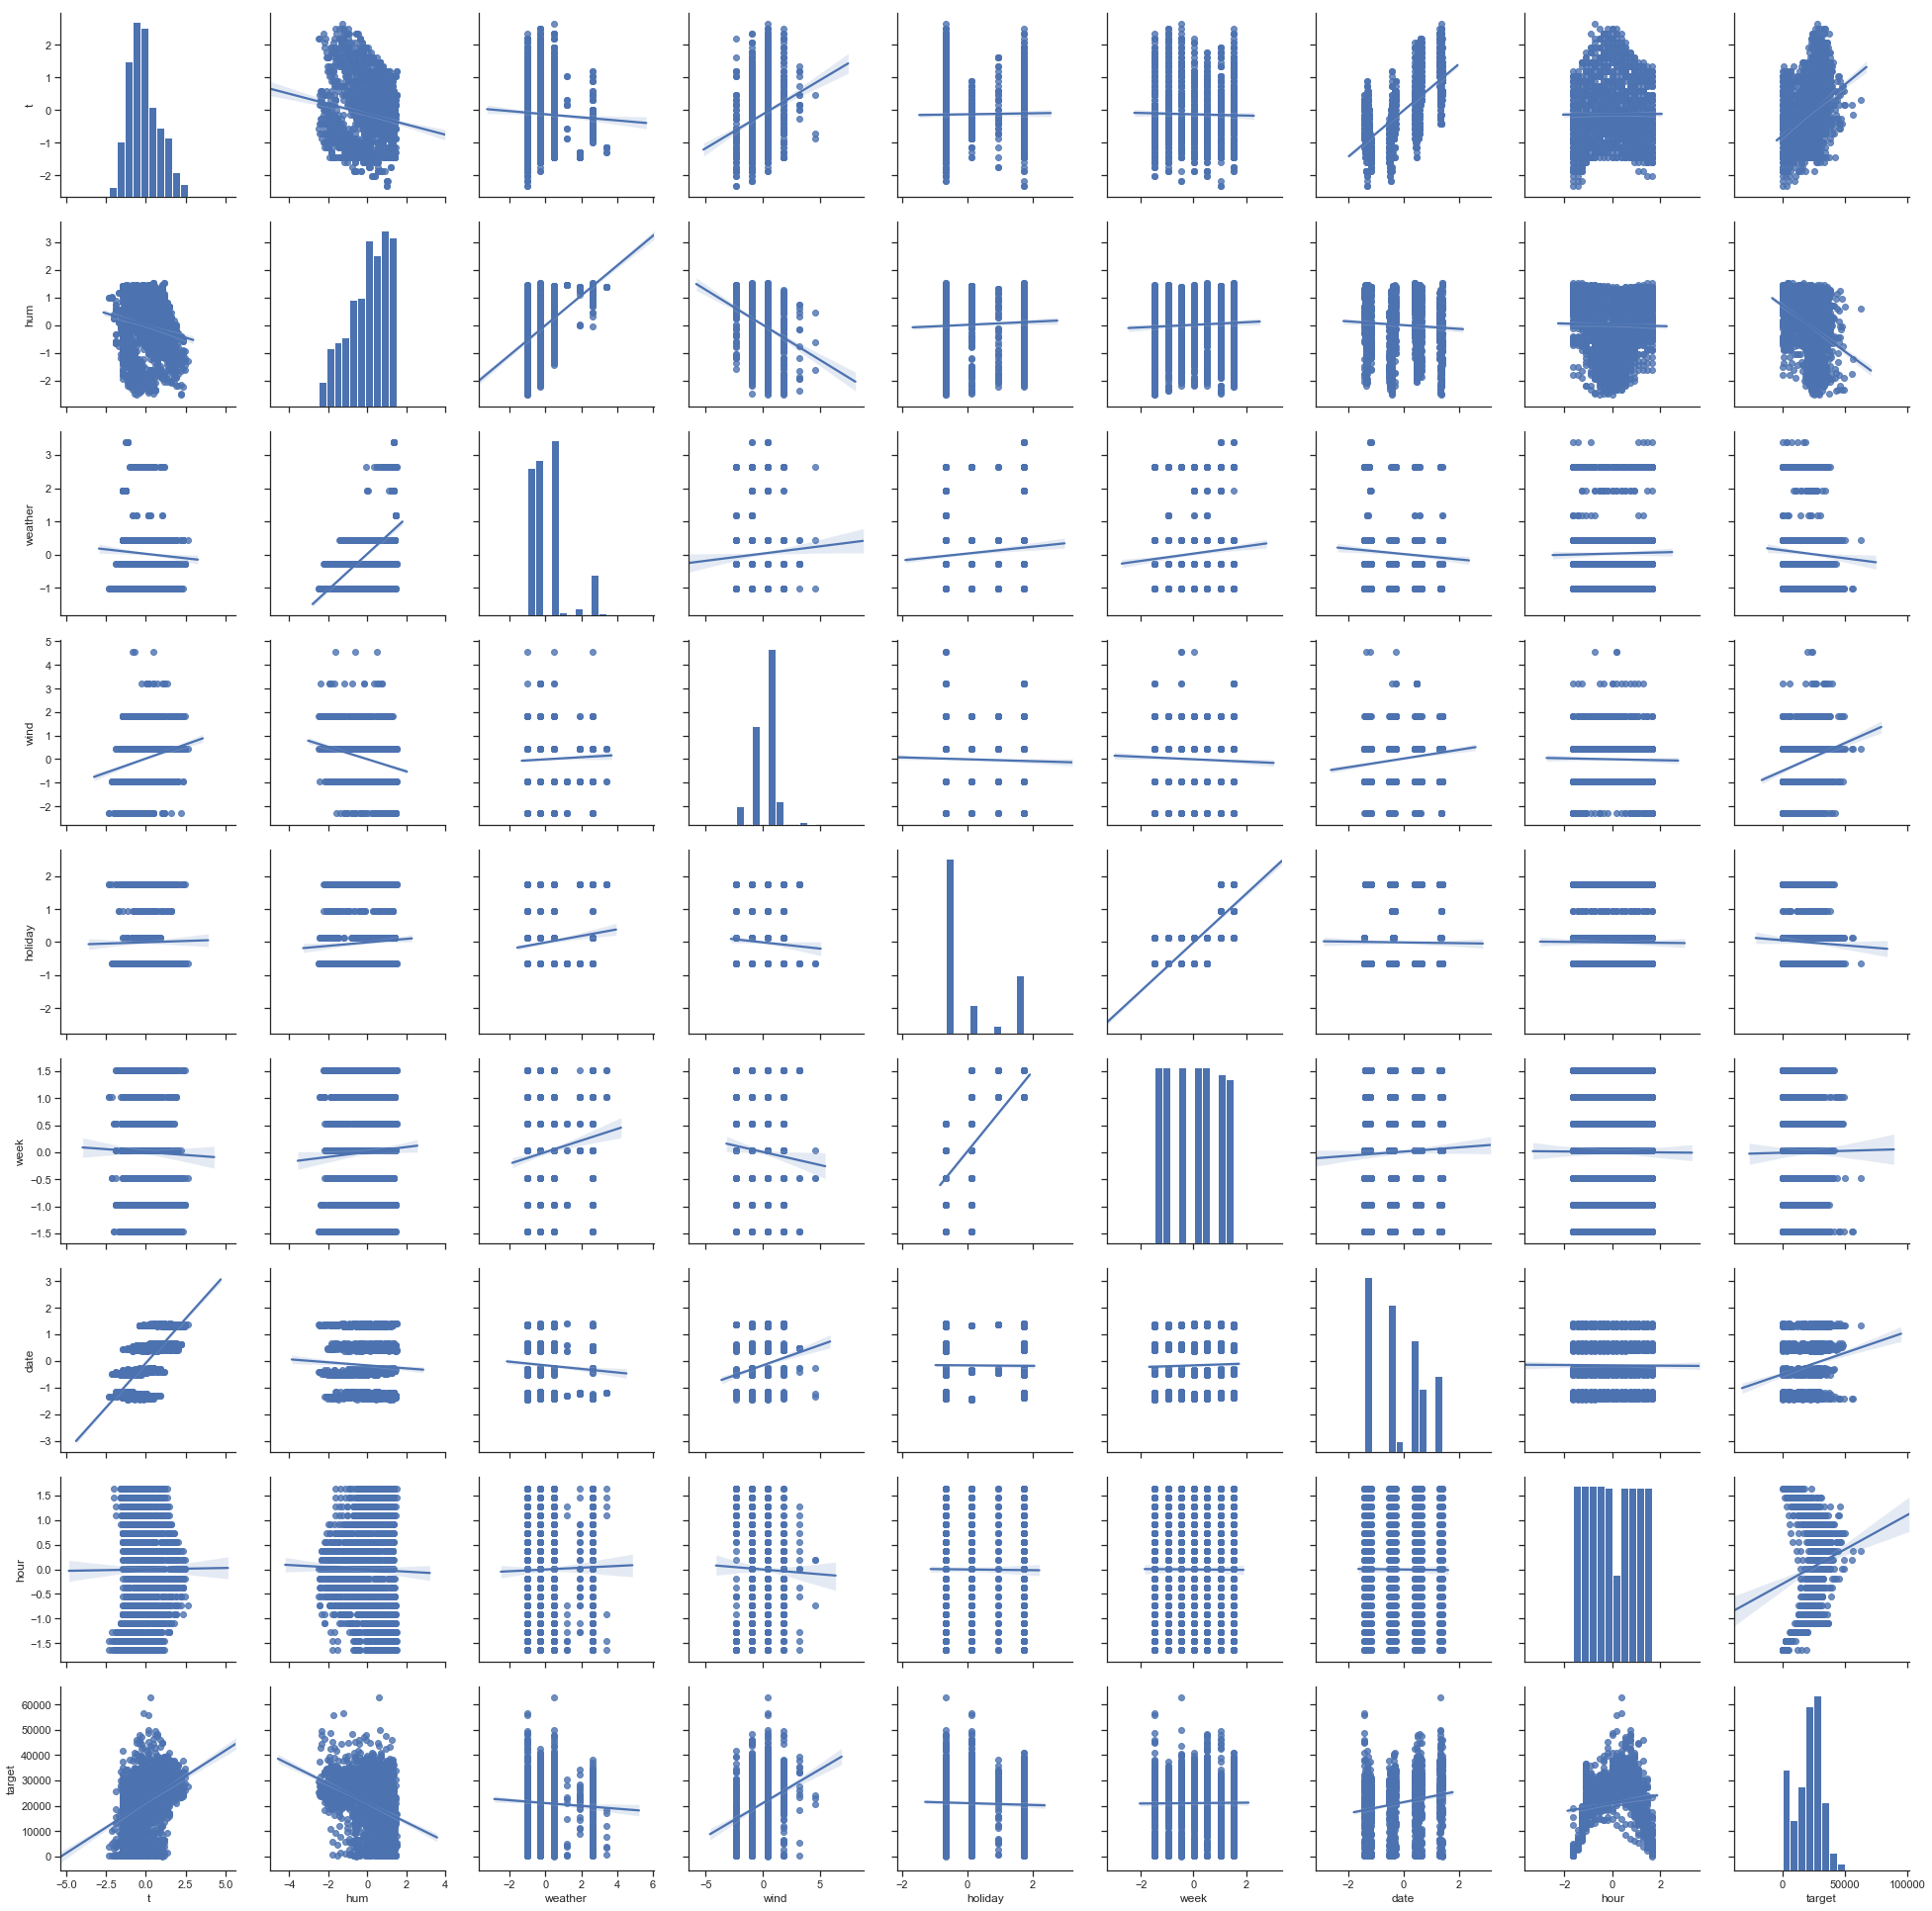

In [34]:
col = ['t','hum','weather','wind','holiday','week','date','hour','target'] 
sns.set(style= 'ticks')
sns.pairplot(train[col],height=3,kind='reg')

In [35]:
print("Find the most important features relative to target")
corr = train.corr()
corr.sort_values(['target'],ascending=False,inplace=True)
corr.target

Find the most important features relative to target


target     1.000000
t          0.356563
wind       0.251369
date       0.188718
hour       0.151362
week       0.007447
holiday   -0.034089
weather   -0.052107
hum       -0.356297
Name: target, dtype: float64

In [36]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from scipy import stats
from time import perf_counter

[NN SVG](http://alexlenail.me/NN-SVG/index.html)

# 4 Train Neural Network

In [37]:
start_time = perf_counter()
num_epochs = 1000
all_scores = []
model = build_model()
# batch_size 训练进入的数据大小为1， verbose = 0 不输出训练数据
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
historys=model.fit(train_data, train_target, epochs = num_epochs, batch_size = 1, verbose = 2)
val_mse, val_mae = model.evaluate(test_data, test_target, verbose = 0)
all_scores.append(val_mae)
print("MSE:", val_mse,"MAE:",val_mae)
end_time = perf_counter()
trainingtime = end_time - start_time
print(trainingtime)

Epoch 1/1000
 - 8s - loss: 130019519.8440 - mae: 9020.2363
Epoch 2/1000
 - 7s - loss: 90694157.5417 - mae: 7561.9854
Epoch 3/1000
 - 7s - loss: 73352791.9641 - mae: 6703.0425
Epoch 4/1000
 - 7s - loss: 45816306.6382 - mae: 5224.3047
Epoch 5/1000
 - 7s - loss: 37235374.0847 - mae: 4710.6987
Epoch 6/1000
 - 7s - loss: 34685423.2908 - mae: 4533.4390
Epoch 7/1000
 - 7s - loss: 32521182.8663 - mae: 4289.2539
Epoch 8/1000
 - 7s - loss: 30892621.5573 - mae: 4210.0195
Epoch 9/1000
 - 8s - loss: 27859322.7835 - mae: 3964.4861
Epoch 10/1000
 - 8s - loss: 26277408.6309 - mae: 3834.0200
Epoch 11/1000
 - 8s - loss: 24232247.7968 - mae: 3652.0249
Epoch 12/1000
 - 8s - loss: 23251846.5349 - mae: 3588.4297
Epoch 13/1000
 - 8s - loss: 22112479.2392 - mae: 3462.1265
Epoch 14/1000
 - 8s - loss: 20272691.8639 - mae: 3358.7795
Epoch 15/1000
 - 8s - loss: 19348970.7270 - mae: 3219.5940
Epoch 16/1000
 - 8s - loss: 18746141.0018 - mae: 3196.3499
Epoch 17/1000
 - 8s - loss: 17576507.5211 - mae: 3126.3015
Epoch

 - 8s - loss: 2202167.0883 - mae: 1076.8605
Epoch 142/1000
 - 8s - loss: 2835021.1275 - mae: 1172.4225
Epoch 143/1000
 - 8s - loss: 2203373.2395 - mae: 1088.6569
Epoch 144/1000
 - 8s - loss: 2394975.4151 - mae: 1149.4681
Epoch 145/1000
 - 8s - loss: 2441659.2649 - mae: 1141.2804
Epoch 146/1000
 - 8s - loss: 2404784.6200 - mae: 1115.0756
Epoch 147/1000
 - 8s - loss: 2731337.8742 - mae: 1196.6477
Epoch 148/1000
 - 8s - loss: 2334440.6486 - mae: 1095.4205
Epoch 149/1000
 - 8s - loss: 2462711.1859 - mae: 1113.2979
Epoch 150/1000
 - 8s - loss: 2325064.6655 - mae: 1099.1328
Epoch 151/1000
 - 8s - loss: 2388140.0835 - mae: 1128.6803
Epoch 152/1000
 - 8s - loss: 2248841.5289 - mae: 1097.7944
Epoch 153/1000
 - 8s - loss: 2376361.1223 - mae: 1125.9568
Epoch 154/1000
 - 8s - loss: 2300679.3617 - mae: 1091.9524
Epoch 155/1000
 - 8s - loss: 2252620.1502 - mae: 1088.8129
Epoch 156/1000
 - 8s - loss: 2084416.3443 - mae: 1066.1902
Epoch 157/1000
 - 8s - loss: 2313422.4410 - mae: 1096.7826
Epoch 158/10

Epoch 282/1000
 - 8s - loss: 1254969.8253 - mae: 825.2773
Epoch 283/1000
 - 8s - loss: 1249498.6851 - mae: 829.2366
Epoch 284/1000
 - 8s - loss: 1398699.6335 - mae: 838.9711
Epoch 285/1000
 - 8s - loss: 1378528.4336 - mae: 826.1330
Epoch 286/1000
 - 8s - loss: 1114720.1524 - mae: 762.5945
Epoch 287/1000
 - 7s - loss: 1195617.2316 - mae: 803.1873
Epoch 288/1000
 - 7s - loss: 1312503.7071 - mae: 836.1881
Epoch 289/1000
 - 8s - loss: 1428784.8631 - mae: 832.1612
Epoch 290/1000
 - 8s - loss: 1361316.3660 - mae: 801.7286
Epoch 291/1000
 - 8s - loss: 1156931.1597 - mae: 778.9621
Epoch 292/1000
 - 8s - loss: 1178118.6056 - mae: 777.7411
Epoch 293/1000
 - 8s - loss: 1362749.6730 - mae: 839.2780
Epoch 294/1000
 - 8s - loss: 1290834.5297 - mae: 815.0480
Epoch 295/1000
 - 8s - loss: 1107717.7639 - mae: 756.7818
Epoch 296/1000
 - 8s - loss: 1721201.8576 - mae: 918.2253
Epoch 297/1000
 - 8s - loss: 1078612.8088 - mae: 763.3229
Epoch 298/1000
 - 8s - loss: 1072440.6812 - mae: 755.2488
Epoch 299/1000

 - 8s - loss: 861910.1981 - mae: 664.6370
Epoch 425/1000
 - 7s - loss: 883297.9696 - mae: 669.7949
Epoch 426/1000
 - 7s - loss: 843345.9544 - mae: 657.4428
Epoch 427/1000
 - 7s - loss: 926828.5961 - mae: 678.9597
Epoch 428/1000
 - 8s - loss: 1031696.1759 - mae: 703.7027
Epoch 429/1000
 - 8s - loss: 759893.3934 - mae: 630.3032
Epoch 430/1000
 - 8s - loss: 830535.4267 - mae: 670.7927
Epoch 431/1000
 - 8s - loss: 872852.6809 - mae: 679.6027
Epoch 432/1000
 - 8s - loss: 787247.3739 - mae: 647.4357
Epoch 433/1000
 - 8s - loss: 1029195.7535 - mae: 714.5135
Epoch 434/1000
 - 8s - loss: 784502.8792 - mae: 633.4357
Epoch 435/1000
 - 8s - loss: 914239.5261 - mae: 696.9340
Epoch 436/1000
 - 7s - loss: 824320.7201 - mae: 658.6626
Epoch 437/1000
 - 7s - loss: 856846.0837 - mae: 652.9789
Epoch 438/1000
 - 7s - loss: 834299.6675 - mae: 669.6871
Epoch 439/1000
 - 7s - loss: 866363.7646 - mae: 674.9424
Epoch 440/1000
 - 7s - loss: 899090.6470 - mae: 687.4627
Epoch 441/1000
 - 8s - loss: 831843.0526 - m

Epoch 568/1000
 - 7s - loss: 605539.0451 - mae: 552.4122
Epoch 569/1000
 - 8s - loss: 604983.1633 - mae: 565.2178
Epoch 570/1000
 - 8s - loss: 641567.1941 - mae: 583.4717
Epoch 571/1000
 - 8s - loss: 624485.3974 - mae: 570.9412
Epoch 572/1000
 - 8s - loss: 745963.2436 - mae: 615.6170
Epoch 573/1000
 - 7s - loss: 898277.6278 - mae: 636.7304
Epoch 574/1000
 - 7s - loss: 521878.1430 - mae: 523.0534
Epoch 575/1000
 - 8s - loss: 670152.2742 - mae: 596.3091
Epoch 576/1000
 - 8s - loss: 722571.5157 - mae: 601.0945
Epoch 577/1000
 - 8s - loss: 628321.6923 - mae: 572.3237
Epoch 578/1000
 - 8s - loss: 626303.8656 - mae: 572.0942
Epoch 579/1000
 - 8s - loss: 641061.9245 - mae: 584.6466
Epoch 580/1000
 - 8s - loss: 688412.8812 - mae: 591.4460
Epoch 581/1000
 - 8s - loss: 636334.4090 - mae: 577.3169
Epoch 582/1000
 - 7s - loss: 615612.8779 - mae: 564.1187
Epoch 583/1000
 - 7s - loss: 725713.4988 - mae: 605.4789
Epoch 584/1000
 - 7s - loss: 538598.9790 - mae: 533.2382
Epoch 585/1000
 - 8s - loss: 60

Epoch 712/1000
 - 8s - loss: 559686.4087 - mae: 524.7211
Epoch 713/1000
 - 7s - loss: 558301.6360 - mae: 534.2532
Epoch 714/1000
 - 8s - loss: 519222.4069 - mae: 505.5368
Epoch 715/1000
 - 8s - loss: 488759.4615 - mae: 492.4261
Epoch 716/1000
 - 8s - loss: 534490.5750 - mae: 525.5221
Epoch 717/1000
 - 7s - loss: 581854.2229 - mae: 545.5819
Epoch 718/1000
 - 8s - loss: 547013.2415 - mae: 523.7427
Epoch 719/1000
 - 8s - loss: 591025.4068 - mae: 529.1719
Epoch 720/1000
 - 8s - loss: 528823.9283 - mae: 515.4521
Epoch 721/1000
 - 8s - loss: 471713.4757 - mae: 485.4769
Epoch 722/1000
 - 7s - loss: 499286.3457 - mae: 507.9845
Epoch 723/1000
 - 7s - loss: 487769.8597 - mae: 504.8305
Epoch 724/1000
 - 7s - loss: 521219.8473 - mae: 522.3387
Epoch 725/1000
 - 8s - loss: 569266.5095 - mae: 534.8143
Epoch 726/1000
 - 8s - loss: 520730.1699 - mae: 490.9383
Epoch 727/1000
 - 8s - loss: 506504.4759 - mae: 514.5703
Epoch 728/1000
 - 8s - loss: 511219.6785 - mae: 507.7934
Epoch 729/1000
 - 7s - loss: 51

Epoch 856/1000
 - 8s - loss: 420548.3676 - mae: 470.0417
Epoch 857/1000
 - 8s - loss: 420501.1983 - mae: 462.0086
Epoch 858/1000
 - 7s - loss: 458170.4934 - mae: 476.8783
Epoch 859/1000
 - 7s - loss: 409158.7113 - mae: 459.2444
Epoch 860/1000
 - 7s - loss: 518451.0360 - mae: 507.7408
Epoch 861/1000
 - 7s - loss: 420318.9117 - mae: 453.3375
Epoch 862/1000
 - 7s - loss: 399033.5731 - mae: 455.9246
Epoch 863/1000
 - 8s - loss: 484836.5947 - mae: 489.4538
Epoch 864/1000
 - 8s - loss: 452060.2048 - mae: 474.9677
Epoch 865/1000
 - 8s - loss: 427758.2236 - mae: 468.1776
Epoch 866/1000
 - 7s - loss: 408604.3964 - mae: 454.9580
Epoch 867/1000
 - 7s - loss: 409975.5623 - mae: 466.2493
Epoch 868/1000
 - 7s - loss: 754750.1763 - mae: 530.5839
Epoch 869/1000
 - 8s - loss: 361752.8506 - mae: 420.9032
Epoch 870/1000
 - 8s - loss: 377787.0576 - mae: 441.2209
Epoch 871/1000
 - 8s - loss: 447166.8034 - mae: 479.2332
Epoch 872/1000
 - 8s - loss: 419456.6862 - mae: 468.7464
Epoch 873/1000
 - 7s - loss: 45

Epoch 1000/1000
 - 7s - loss: 347625.4557 - mae: 431.4701
MSE: 16735455.00456621 MAE: 3097.697265625
7589.681013099


In [50]:
val_mae/target_mean

0.13595992467080514

In [40]:
import math
math.sqrt(25638855.11415525)

5063.482508526642

dict_keys(['loss', 'mae'])


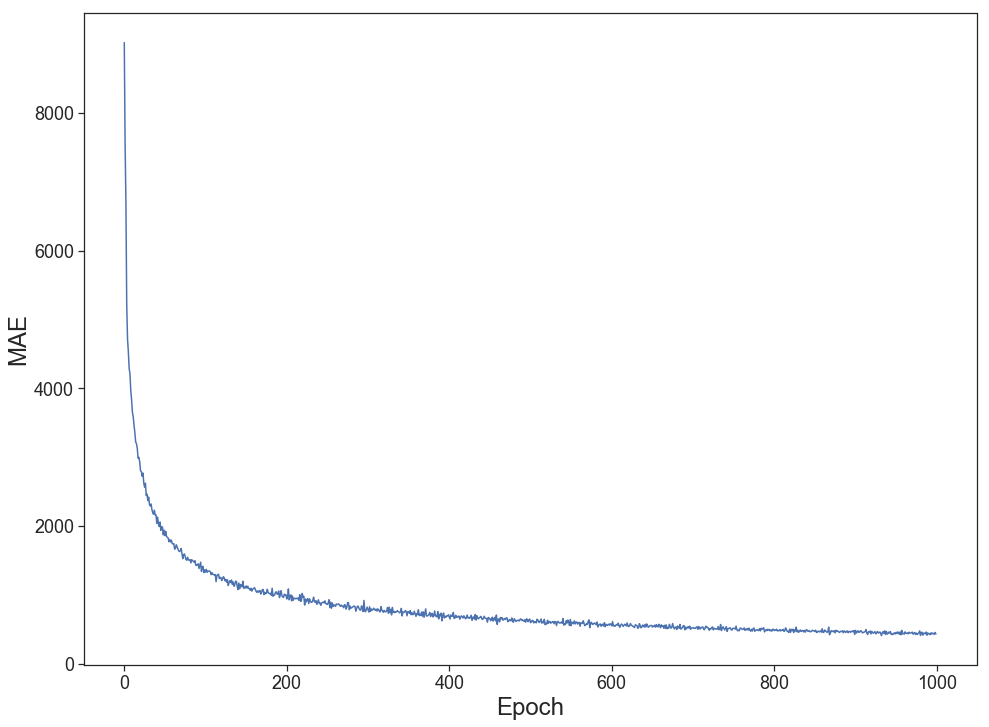

In [42]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 24,
         'axes.titlesize':36,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)
history = historys
plt.figure(figsize=(16,12))
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
#plt.plot(history.history['val_mae'])
#plt.title('Model Accuracy', fontsize=36)
plt.ylabel('MAE',fontsize=24)
plt.xlabel('Epoch',fontsize=24)
#plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')


In [44]:
target_mean = test_target.mean(axis=0)
target_mean

22783.899543378997

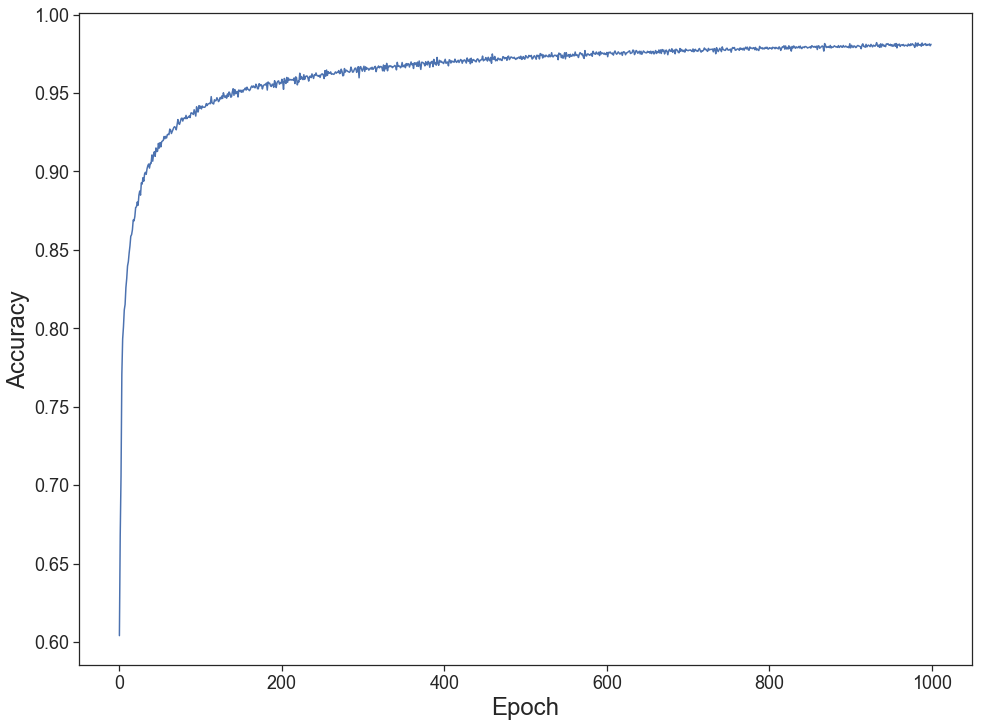

In [45]:
accuracy=[]
plt.figure(figsize=(16,12))
for value in history.history['mae']:
    accuracy.append(1-value/target_mean)
plt.plot(accuracy)
plt.ylabel('Accuracy',)
plt.xlabel('Epoch')
plt.show()

In [46]:
accuracy[-1]

0.9810625002119612

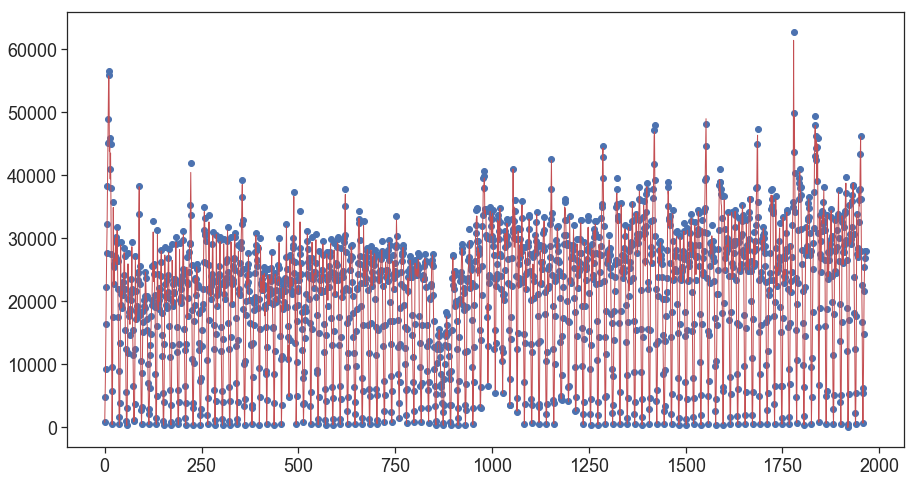

In [47]:
# 输出一个一天/h的训练值与实际值
fig = plt.figure(figsize=(15,8))
y_pred = model.predict(train_data)
x_data = np.linspace(0,len(train_data),len(y_pred))
plt.scatter(x_data,train_target)
plt.plot(x_data,y_pred,'r-',lw=1)

# 5 Prediction Result

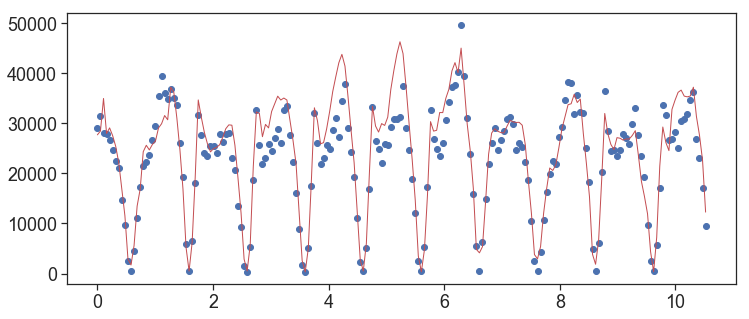

In [51]:
# 输出一个客流量 / h 的预测值与实际值
fig = plt.figure(figsize=(12, 5))
y_pred = model.predict(test_data)
x_data = np.linspace(0,len(y_pred)/19 ,len(y_pred))
plt.scatter(x_data[0:200],test_target[0:200])
plt.plot(x_data[0:200],y_pred[0:200],'r-',lw=1)

In [49]:
1-val_mae/target_mean

0.8640400753291948

In [ ]:
data_set1

# 7 Data for other models
# Evaluation

In [52]:
#Fit the model
X = pd.DataFrame(data, columns=['t','hum','weather','wind','holiday','week','date','hour'])
y = target
X_train = train_data
y_train = train_target
X_test = test_data
y_test = test_target

In [53]:
print(len(X_test),len(y_test))

219 219


In [54]:
error_gbr = 2484.45/target_mean
error_gbr

0.10904410789161775

In [55]:
error_rf = 3023.7/target_mean
error_rf

0.13271213710555035

In [56]:
error_lr = 6826.34/target_mean
error_lr

0.29961245163511685

In [57]:
#Score/Accuracy/MAE
def evaluation(model, y_pred):
    score = model.score(X_test, y_test)*100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print("Accuracy --> ", score)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    return {'score':score,'mae':mae,'mse':mse,'rmse':rmse}

In [58]:
#Score/Accuracy/MAE
def evaluation_train(model, X_train, y_train):
    score = model.score(X_train, y_train)*100
    y_pred_train = model.predict(X_train)
    mae = metrics.mean_absolute_error(y_train, y_pred_train)
    mse = metrics.mean_squared_error(y_train, y_pred_train)
    rmse = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    print("Accuracy --> ", score)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    return {'score':score,'mae':mae,'mse':mse,'rmse':rmse}

# 8 Linear Regression

In [59]:
#Train the model
from sklearn import linear_model
start = perf_counter()
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)
end = perf_counter()
print(end-start)

0.0008264650005003205


In case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. To see what coefficients our regression model has chosen, execute the following script:

In [60]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
t,3851.976285
hum,-3781.325325
weather,1531.821333
wind,1007.689899
holiday,-1156.569600
week,1102.432827
date,-880.882543
hour,1506.377939


## Making predictions

In [61]:
y_pred_lr = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
df

,Actual,Predicted
0,29043,18022.717437
1,31361,18477.340229
2,27967,17906.314367
3,27811,19566.155816
4,26729,21320.460174
...,...,...
214,38917,25916.249904
215,27345,24352.981685
216,24106,22007.636838
217,19365,22282.689625


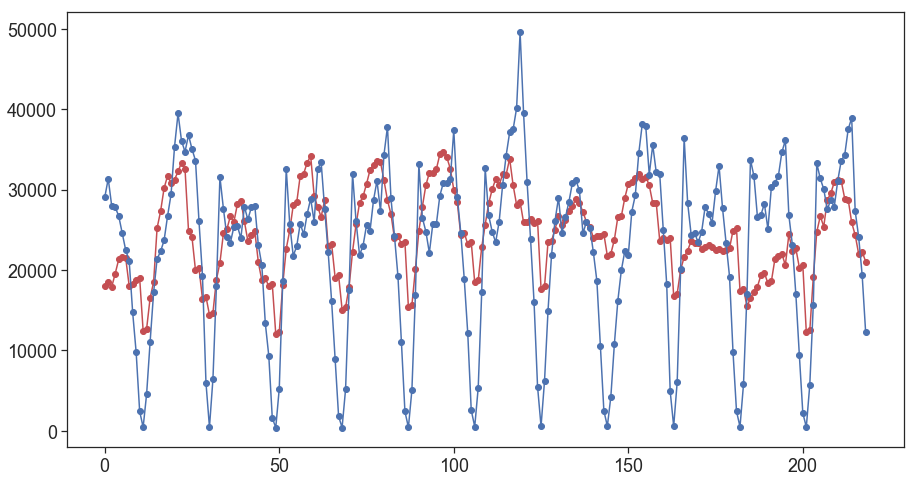

In [62]:
plt.figure(figsize=(15,8))
plt.plot(y_pred_lr, 'o-r')
plt.plot(y_test,'o-b')
plt.show()

In [63]:
def plt_cmp(y_pred, y_test):
    plt.figure(figsize=(15,8))
    plt.plot(y_pred, 'o-r')
    plt.plot(y_test,'o-b')
    plt.show()

## Evaluating the Algorithm

The final step is to evaluate the performance of algorithm. We'll do this by finding the values for MAE, MSE and RMSE. Execute the following script:

In [64]:
#Score/Accuracy
#Return the coefficient of determination R^2 of the prediction.
evaluation(regressor,y_pred_lr)

Accuracy -->  33.61317575223739
MAE: 6826.343785922313
MSE: 75168771.71737745
RMSE: 8669.992601921726


{'score': 33.61317575223739,
 'mae': 6826.343785922313,
 'mse': 75168771.71737745,
 'rmse': 8669.992601921726}

# 9 RandomForestRegression

In [65]:
#Train the model
from sklearn.ensemble import RandomForestRegressor

In [66]:
#Fit
start = perf_counter()
RF = RandomForestRegressor(n_estimators=50)
RF.fit(X_train, y_train)
end = perf_counter()
print(end-start)

0.23826304400063236


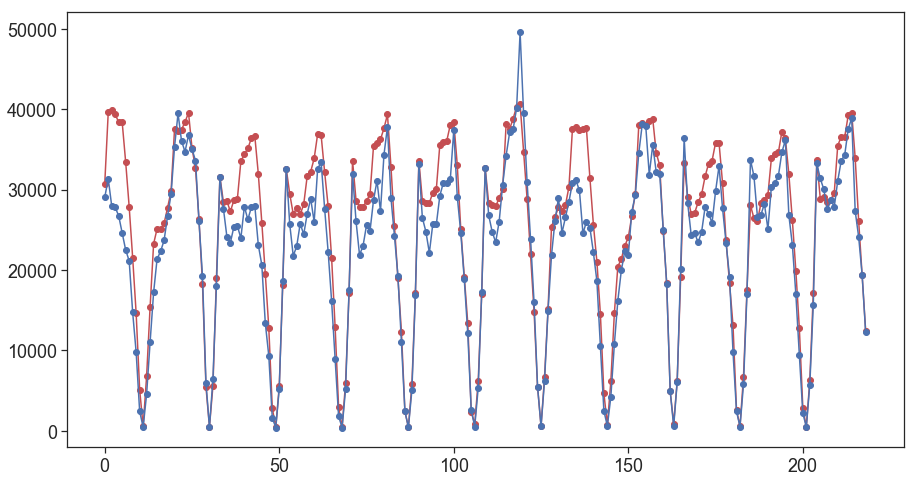

In [67]:
y_pred_rf = RF.predict(X_test)
plt_cmp(y_pred_rf, y_test)

In [68]:
evaluation(RF,y_pred_rf)

Accuracy -->  84.6079360237497
MAE: 3030.08401826484
MSE: 17428195.374611873
RMSE: 4174.709016759357


{'score': 84.6079360237497,
 'mae': 3030.08401826484,
 'mse': 17428195.374611873,
 'rmse': 4174.709016759357}

In [80]:
mae_rf = []
mse_rf = []
mae_train_rf = []
mse_train_rf = []
for n in range(1,500):
    rf_iter = RandomForestRegressor(n_estimators=n)
    rf_iter.fit(X_train, y_train)
    y_pred_rf_iter = rf_iter.predict(X_test)
    res_rf = evaluation(rf_iter,y_pred_rf_iter)
    mae_rf.append(res_rf['mae'])
    mse_rf.append(res_rf['mse'])
    res_train_rf = evaluation_train(rf_iter,X_train, y_train)
    mae_train_rf.append(res_train_rf['mae'])
    mse_train_rf.append(res_train_rf['mse'])

Accuracy -->  79.99486899753614
MAE: 3336.607305936073
MSE: 22651499.639269408
RMSE: 4759.3591626677435
Accuracy -->  92.44504625921196
MAE: 1160.397455470738
MSE: 8755333.26259542
RMSE: 2958.9412401390164
Accuracy -->  85.07488394376723
MAE: 2994.207762557078
MSE: 16899477.485159818
RMSE: 4110.897406304348
Accuracy -->  96.92850123754998
MAE: 918.5124681933843
MSE: 3559518.192111959
RMSE: 1886.6685432560641
Accuracy -->  90.06817242800214
MAE: 2426.4657534246576
MSE: 11245654.359208522
RMSE: 3353.4540937976954
Accuracy -->  97.35690108565124
MAE: 898.8245971162003
MSE: 3063051.427594006
RMSE: 1750.1575436497155
Accuracy -->  78.70884191465586
MAE: 3303.942922374429
MSE: 24107648.16438356
RMSE: 4909.9539880108405
Accuracy -->  97.53469078581809
MAE: 938.3858778625954
MSE: 2857013.359192112
RMSE: 1690.2702030125574
Accuracy -->  85.27175222733058
MAE: 3044.2584474885844
MSE: 16676566.580273973
RMSE: 4083.6952114811374
Accuracy -->  97.78259054209015
MAE: 878.9281424936386
MSE: 2569725.6

Accuracy -->  85.365913517092
MAE: 2947.0552293976957
MSE: 16569949.211919775
RMSE: 4070.6202490431083
Accuracy -->  98.92331783194228
MAE: 718.908421180177
MSE: 1247752.3387530076
RMSE: 1117.0283518125257
Accuracy -->  81.95282474455924
MAE: 3284.1164914516303
MSE: 20434536.70651296
RMSE: 4520.45757711683
Accuracy -->  99.01647203884131
MAE: 706.28925971951
MSE: 1139797.1937981744
RMSE: 1067.6128482732747
Accuracy -->  85.11656727602085
MAE: 3006.073889580739
MSE: 16852280.094380923
RMSE: 4105.1528710123475
Accuracy -->  99.00990208327616
MAE: 696.6098427018273
MSE: 1147411.0260554014
RMSE: 1071.1727339955034
Accuracy -->  84.33596622471016
MAE: 3093.470725520041
MSE: 17736142.560965102
RMSE: 4211.42999003487
Accuracy -->  98.96075448527107
MAE: 707.3887362171332
MSE: 1204367.5097552852
RMSE: 1097.4367907789883
Accuracy -->  86.54591600889698
MAE: 2919.6932698034543
MSE: 15233850.687287983
RMSE: 3903.0565826398138
Accuracy -->  98.97417328503796
MAE: 708.6294390972453
MSE: 1188816.644

Accuracy -->  84.70839588688096
MAE: 3048.289787281434
MSE: 17314446.229295183
RMSE: 4161.063112870938
Accuracy -->  99.01655799714419
MAE: 697.0504933904301
MSE: 1139697.577888631
RMSE: 1067.5661936801066
Accuracy -->  84.85355527487765
MAE: 3059.4797821422676
MSE: 17150084.5050736
RMSE: 4141.266050988948
Accuracy -->  99.0321000875105
MAE: 688.2492228455808
MSE: 1121686.0604891744
RMSE: 1059.0968135582198
Accuracy -->  84.99186074920296
MAE: 3085.047836486193
MSE: 16993483.36102698
RMSE: 4122.315291317123
Accuracy -->  99.07723527340639
MAE: 685.8800254452925
MSE: 1069379.506677442
RMSE: 1034.1080730162791
Accuracy -->  84.16497454434312
MAE: 3101.647166263766
MSE: 17929753.78928821
RMSE: 4234.353999052065
Accuracy -->  99.0786229335874
MAE: 681.6607633587786
MSE: 1067771.3661438494
RMSE: 1033.3302309251624
Accuracy -->  84.95325934380449
MAE: 3047.634809387278
MSE: 17037191.13381539
RMSE: 4127.613249059968
Accuracy -->  99.02623728882435
MAE: 695.116042369371
MSE: 1128480.3782454447

Accuracy -->  84.47404214691238
MAE: 3082.8489407889815
MSE: 17579801.335228045
RMSE: 4192.827367687351
Accuracy -->  99.05752520728801
MAE: 691.6888666416386
MSE: 1092221.2345575932
RMSE: 1045.0938879151447
Accuracy -->  85.02853931400094
MAE: 3034.980807068345
MSE: 16951952.790835347
RMSE: 4117.274922911433
Accuracy -->  99.09652271784721
MAE: 680.9840956577505
MSE: 1047027.5493184736
RMSE: 1023.2436412304127
Accuracy -->  85.09773321836394
MAE: 3008.9873324495506
MSE: 16873605.6058294
RMSE: 4107.749457528952
Accuracy -->  99.09250217733648
MAE: 684.1790117376672
MSE: 1051686.8991007435
RMSE: 1025.517868737909
Accuracy -->  84.89197364081099
MAE: 3018.9022100456623
MSE: 17106583.985033352
RMSE: 4136.010636474881
Accuracy -->  99.06218549122899
MAE: 689.769058524173
MSE: 1086820.4948043888
RMSE: 1042.5068320180874
Accuracy -->  85.35361264013976
MAE: 2984.1936290497933
MSE: 16583877.304158311
RMSE: 4072.330696807212
Accuracy -->  99.08653942657354
MAE: 691.7559392544126
MSE: 1058597.0

Accuracy -->  85.49571395275152
MAE: 2966.207396132815
MSE: 16422978.191277295
RMSE: 4052.527383161932
Accuracy -->  99.06563737899528
MAE: 688.0656362893852
MSE: 1082820.1489629715
RMSE: 1040.5864447334357
Accuracy -->  85.06812590701995
MAE: 3038.539541137911
MSE: 16907129.505380236
RMSE: 4111.828000461624
Accuracy -->  99.10488644567106
MAE: 679.0000842972884
MSE: 1037334.9387575123
RMSE: 1018.4964107730141
Accuracy -->  85.81362483898344
MAE: 2978.763141775254
MSE: 16063012.62424774
RMSE: 4007.868838204132
Accuracy -->  99.0833025975165
MAE: 682.8851051945634
MSE: 1062348.1671856765
RMSE: 1030.7027540400175
Accuracy -->  85.08538004044861
MAE: 3012.9035837830356
MSE: 16887592.917637475
RMSE: 4109.451656564106
Accuracy -->  99.08801567224755
MAE: 687.5380214357314
MSE: 1056886.2489029272
RMSE: 1028.0497307537837
Accuracy -->  84.54201968860023
MAE: 3098.7279804148106
MSE: 17502831.418818533
RMSE: 4183.638538260509
Accuracy -->  99.11694068482079
MAE: 680.0860388117355
MSE: 1023365.4

Accuracy -->  86.40958202556557
MAE: 2920.3350287083504
MSE: 15388219.542651718
RMSE: 3922.7821176623765
Accuracy -->  99.09416524411748
MAE: 681.6339027032474
MSE: 1049759.5935995772
RMSE: 1024.5777635687675
Accuracy -->  85.12259306762651
MAE: 3019.544751107812
MSE: 16845457.183980294
RMSE: 4104.3217690600595
Accuracy -->  99.07002404606594
MAE: 687.305215658256
MSE: 1077736.5000839203
RMSE: 1038.1408864330122
Accuracy -->  85.49575920132119
MAE: 2983.5264571582056
MSE: 16422926.957023464
RMSE: 4052.521061885239
Accuracy -->  99.08751727925608
MAE: 682.2562515591477
MSE: 1057463.8297705154
RMSE: 1028.330603342386
Accuracy -->  84.73177767804985
MAE: 3036.9015480565763
MSE: 17287971.38970715
RMSE: 4157.880636779651
Accuracy -->  99.09934790193117
MAE: 679.6250158257309
MSE: 1043753.4818612934
RMSE: 1021.6425411372088
Accuracy -->  85.54677624462096
MAE: 2941.4155472802236
MSE: 16365161.149953343
RMSE: 4045.387639022167
Accuracy -->  99.06940022445654
MAE: 688.0862546011512
MSE: 107845

Accuracy -->  84.40355401835109
MAE: 3087.5683233329555
MSE: 17659613.950225785
RMSE: 4202.334345363989
Accuracy -->  99.0963588296356
MAE: 678.1131411267428
MSE: 1047217.4771405822
RMSE: 1023.3364437664585
Accuracy -->  84.13730721335429
MAE: 3100.759794802413
MSE: 17961081.079163805
RMSE: 4238.051566364407
Accuracy -->  99.10235933001393
MAE: 678.5876606037759
MSE: 1040263.5787638567
RMSE: 1019.933124652718
Accuracy -->  84.82952250665447
MAE: 3041.065143349053
MSE: 17177296.4358863
RMSE: 4144.550209116341
Accuracy -->  99.0992650824908
MAE: 681.3956722145747
MSE: 1043849.4601856819
RMSE: 1021.6895126141219
Accuracy -->  84.41024396860121
MAE: 3074.8273227099057
MSE: 17652039.02329037
RMSE: 4201.432972604748
Accuracy -->  99.1005899865207
MAE: 681.201846601236
MSE: 1042314.0469031287
RMSE: 1020.9378271487097
Accuracy -->  83.68123692697952
MAE: 3151.280450681219
MSE: 18477482.392708175
RMSE: 4298.544217837962
Accuracy -->  99.07179913352394
MAE: 686.2041746829682
MSE: 1075679.3753418

Accuracy -->  84.89023861918115
MAE: 3053.1252793160397
MSE: 17108548.523121994
RMSE: 4136.248121561615
Accuracy -->  99.10573397991487
MAE: 683.8322144623103
MSE: 1036352.7428353602
RMSE: 1018.0141172082832
Accuracy -->  85.02066696852964
MAE: 3023.103360924214
MSE: 16960866.52554575
RMSE: 4118.357260552531
Accuracy -->  99.10608075996548
MAE: 682.9652361556929
MSE: 1035950.8641454511
RMSE: 1017.8167144164273
Accuracy -->  85.85069105618514
MAE: 2954.942954530838
MSE: 16021043.12125027
RMSE: 4002.6295258555056
Accuracy -->  99.09794450796024
MAE: 680.5849621904455
MSE: 1045379.8560702872
RMSE: 1022.4381918093079
Accuracy -->  84.10717052856562
MAE: 3117.564031082272
MSE: 17995204.380057704
RMSE: 4242.0754802405045
Accuracy -->  99.09958702771378
MAE: 682.7148859425919
MSE: 1043476.3622401317
RMSE: 1021.5069075831703
Accuracy -->  84.74699132227394
MAE: 3037.9016668263243
MSE: 17270745.216251377
RMSE: 4155.80861160032
Accuracy -->  99.09632698623395
MAE: 682.2466645313974
MSE: 1047254.

Accuracy -->  84.93426685555639
MAE: 3024.740392523894
MSE: 17058696.033765707
RMSE: 4130.217431778345
Accuracy -->  99.10334094935757
MAE: 679.6405986755805
MSE: 1039125.9934409532
RMSE: 1019.3752956791494
Accuracy -->  84.7438675224225
MAE: 3056.5421208137186
MSE: 17274282.246386267
RMSE: 4156.234142392157
Accuracy -->  99.09869752362941
MAE: 677.6256942310873
MSE: 1044507.196440337
RMSE: 1022.0113484890161
Accuracy -->  85.0432878642643
MAE: 3059.780272281414
MSE: 16935253.23605965
RMSE: 4115.246436856443
Accuracy -->  99.0944211711077
MAE: 684.4979078314957
MSE: 1049463.0032871685
RMSE: 1024.4330155198868
Accuracy -->  85.57834975221148
MAE: 2985.2332701088867
MSE: 16329410.956879891
RMSE: 4040.9665869541523
Accuracy -->  99.0972232111018
MAE: 682.1421726365238
MSE: 1046215.757201319
RMSE: 1022.8468884448537
Accuracy -->  85.51156019491883
MAE: 2967.047679076674
MSE: 16405035.736979323
RMSE: 4050.3130418498918
Accuracy -->  99.11050917238975
MAE: 684.094801667213
MSE: 1030818.83714

Accuracy -->  84.40725670336931
MAE: 3096.781704886602
MSE: 17655421.457392607
RMSE: 4201.83548671204
Accuracy -->  99.07913009773735
MAE: 684.1730392363601
MSE: 1067183.620499876
RMSE: 1033.0457978714574
Accuracy -->  85.38560946436152
MAE: 3017.1284450985568
MSE: 16547647.796227181
RMSE: 4067.880012516001
Accuracy -->  99.07961357204097
MAE: 683.671482346014
MSE: 1066623.3286969909
RMSE: 1032.7745778711785
Accuracy -->  84.77662051485298
MAE: 3048.104621405992
MSE: 17237196.54091737
RMSE: 4151.770289998878
Accuracy -->  99.10148727617282
MAE: 681.9901001034589
MSE: 1041274.1901142035
RMSE: 1020.4284345872588
Accuracy -->  86.2447520582295
MAE: 2925.7492837930827
MSE: 15574853.958851945
RMSE: 3946.4989495566756
Accuracy -->  99.09831218000514
MAE: 680.7944815085921
MSE: 1044953.7659319497
RMSE: 1022.2298009410358
Accuracy -->  84.62887924901466
MAE: 3068.2332884197917
MSE: 17404481.685385037
RMSE: 4171.86788925357
Accuracy -->  99.10194036478407
MAE: 680.2773050237073
MSE: 1040749.111

Accuracy -->  84.51515490713247
MAE: 3066.761977782321
MSE: 17533249.994315576
RMSE: 4187.272381194657
Accuracy -->  99.07198578254291
MAE: 684.136150038611
MSE: 1075463.0703292652
RMSE: 1037.0453559653336
Accuracy -->  84.60948933866058
MAE: 3048.965781751023
MSE: 17426436.580223624
RMSE: 4174.498362704629
Accuracy -->  99.11255072906519
MAE: 680.6508413362883
MSE: 1028452.904844802
RMSE: 1014.1266710055514
Accuracy -->  85.25992150862905
MAE: 3021.984922464849
MSE: 16689962.3196154
RMSE: 4085.335031501749
Accuracy -->  99.13018806320521
MAE: 674.1723024210818
MSE: 1008013.237898077
RMSE: 1003.9986244502912
Accuracy -->  85.06360102464629
MAE: 3049.6223349681495
MSE: 16912252.959530167
RMSE: 4112.45096743173
Accuracy -->  99.10095438572422
MAE: 680.3112732070492
MSE: 1041891.7496162326
RMSE: 1020.7309878788988
Accuracy -->  84.74026056711256
MAE: 3045.389893605057
MSE: 17278366.345955122
RMSE: 4156.725435478644
Accuracy -->  99.12145280839792
MAE: 675.3278018024794
MSE: 1018136.406033

Accuracy -->  85.26718199595695
MAE: 3008.6153226306324
MSE: 16681741.382393423
RMSE: 4084.328755425232
Accuracy -->  99.08805215200451
MAE: 681.9099225127513
MSE: 1056843.9730081325
RMSE: 1028.0291693371996
Accuracy -->  84.06160257274342
MAE: 3118.0553408165574
MSE: 18046800.26986927
RMSE: 4248.152571397274
Accuracy -->  99.11005022157028
MAE: 678.3298514063837
MSE: 1031350.7090134039
RMSE: 1015.5543850594137
Accuracy -->  85.22085877774607
MAE: 3004.166368423218
MSE: 16734192.44409675
RMSE: 4090.7447297645876
Accuracy -->  99.10193545547841
MAE: 678.5578983563717
MSE: 1040754.8012050786
RMSE: 1020.1739073339793
Accuracy -->  85.42399022100021
MAE: 2998.779057000667
MSE: 16504189.860608097
RMSE: 4062.534905771038
Accuracy -->  99.0966414173695
MAE: 681.9159253223547
MSE: 1046889.9900545186
RMSE: 1023.1764217643596
Accuracy -->  86.00145182678466
MAE: 2918.09182586973
MSE: 15850339.03836118
RMSE: 3981.2484271094136
Accuracy -->  99.09880040487086
MAE: 673.670129736761
MSE: 1044387.968

Accuracy -->  84.73309920908115
MAE: 3059.5407358987477
MSE: 17286475.04061178
RMSE: 4157.700691561597
Accuracy -->  99.1183682089283
MAE: 674.3951474454404
MSE: 1021711.1064569473
RMSE: 1010.7972627866319
Accuracy -->  84.56569611689831
MAE: 3068.9209847131224
MSE: 17476022.966177724
RMSE: 4180.433346697173
Accuracy -->  99.10452983752184
MAE: 677.7582486473956
MSE: 1037748.2070974315
RMSE: 1018.6992721590761
Accuracy -->  84.46835703829765
MAE: 3074.890420393223
MSE: 17586238.49556055
RMSE: 4193.594936991477
Accuracy -->  99.09734695358458
MAE: 682.1819937753664
MSE: 1046072.3537189626
RMSE: 1022.7767858721485
Accuracy -->  85.69650330136254
MAE: 2966.711359035918
MSE: 16195627.525237095
RMSE: 4024.379147798713
Accuracy -->  99.11759878670647
MAE: 674.0803934839066
MSE: 1022602.7794178958
RMSE: 1011.2382406821331
Accuracy -->  84.63752316986402
MAE: 3056.471428302986
MSE: 17394694.307837903
RMSE: 4170.694703264422
Accuracy -->  99.11385311346008
MAE: 676.2460790165342
MSE: 1026943.58

Text(0.5,0,'Number of Estimators')

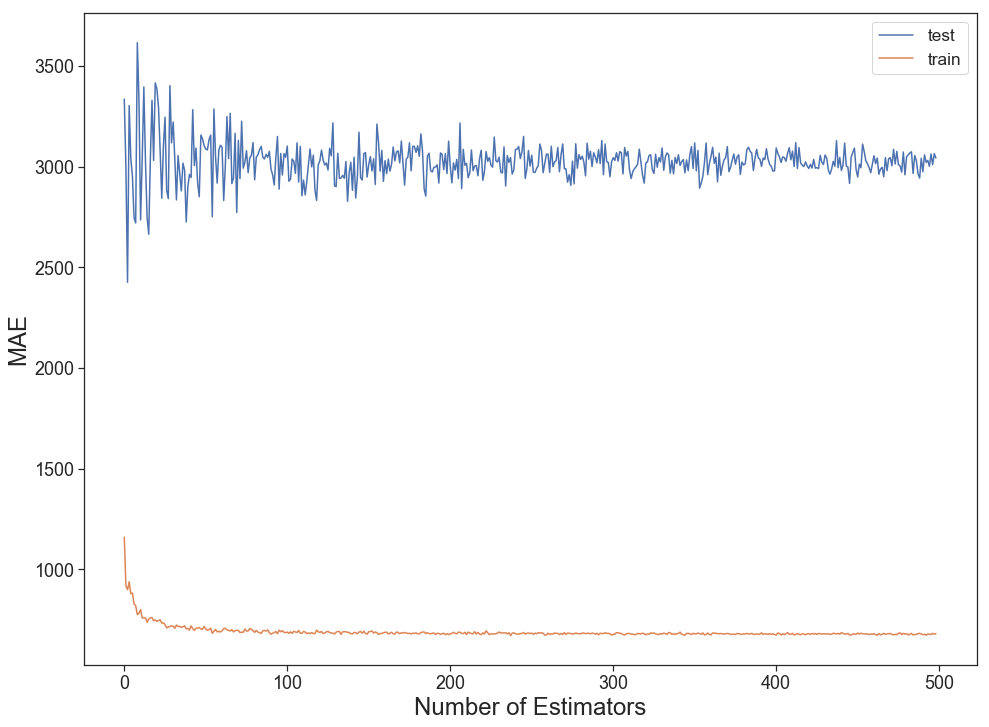

In [81]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 24,
         'axes.titlesize':36,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)
plt.plot(mae_rf) 
plt.plot(mae_train_rf)
plt.legend(['test', 'train'], loc='upper right')
plt.ylabel('MAE',fontsize=24)
plt.xlabel('Number of Estimators',fontsize=24)

Text(0.5,0,'Number of Estimators')

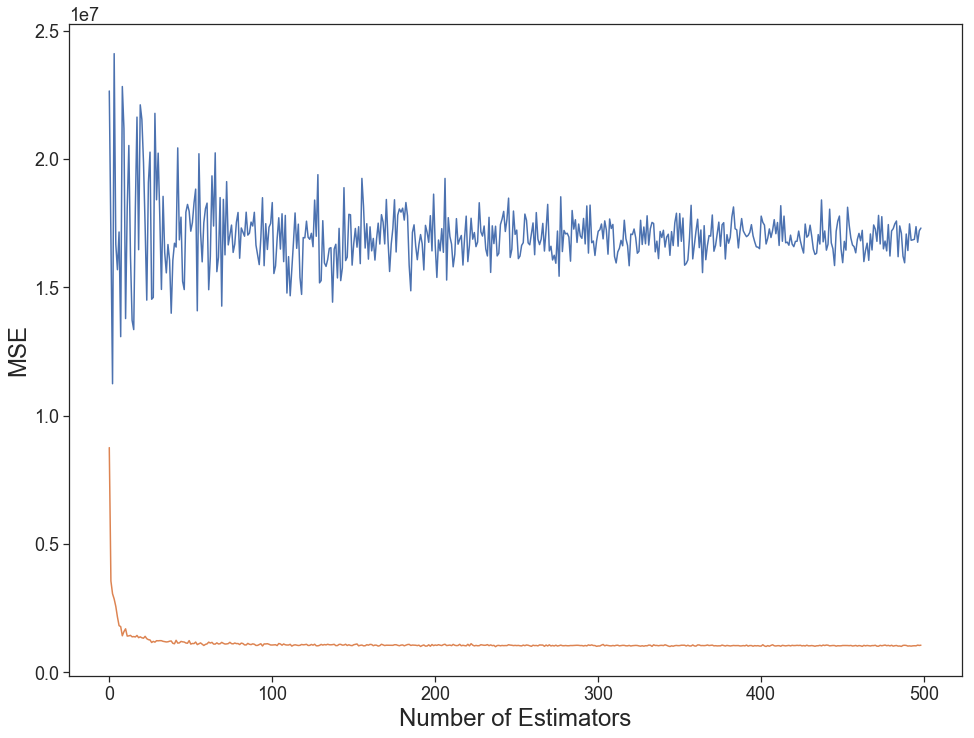

In [82]:
plt.plot(mse_rf)
plt.plot(mse_train_rf)
plt.ylabel('MSE',fontsize=24)
plt.xlabel('Number of Estimators',fontsize=24)

# 10 GradientBoostingRegressor

Gradient boosting has become a big part of Kaggle competition winners’ toolkits. It was initially explored in earnest by Jerome Friedman in the paper Greedy Function Approximation: A Gradient Boosting Machine. In this post we’ll take a look at gradient boosting and its use in python with the scikit-learn library.
Gradient boosting is a boosting ensemble method.
Ensemble machine learning methods are ones in which a number of predictors are aggregated to form a final prediction, which has lower bias and variance than any of the individual predictors.
Ensemble machine learning methods come in 2 different flavours – bagging and boosting.
Bagging is a technique in which many predictors are trained independently of one another and then they are aggregated afterwards using an average (majority vote/mode, mean, weighted mean). Random forests are an example of bagging.
Boosting is a technique in which the predictors are trained sequentially (the error of one stage is passed as input into the next stage).
Gradient boosting produces an ensemble of decision trees that, on their own, are weak decision models. Let’s take a look at how this model works.
We’ll start with some imports.

In [72]:
#Train the model
from sklearn.ensemble import GradientBoostingRegressor

0.25412364099975093
0.3798730100006651
0.5407391869994171
0.9401619700001902


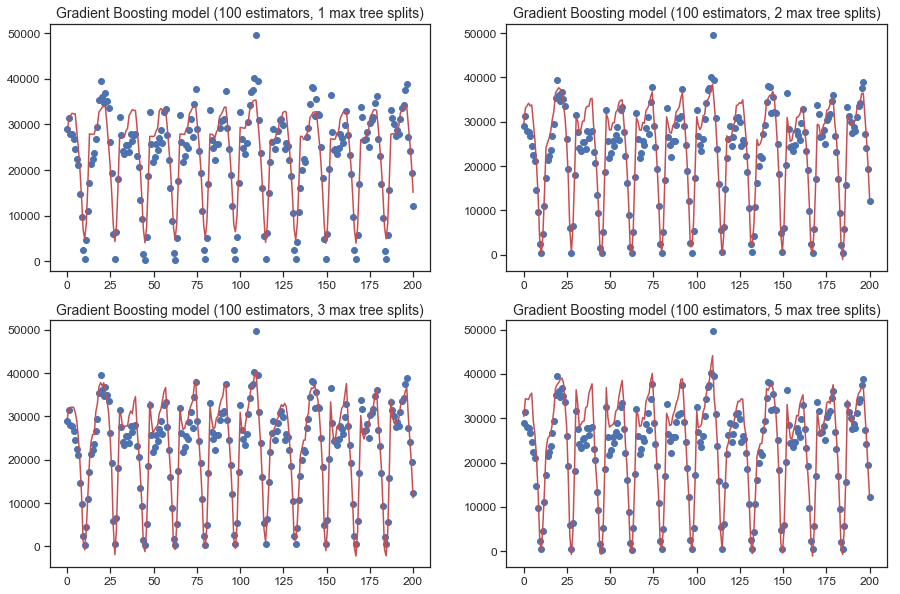

In [76]:
params_gbr = {}
params_gbr['n_estimators'] = 1000
params_gbr['criterion'] = 'mse'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 16,
         'axes.titlesize':14,
         'xtick.labelsize':12,
         'ytick.labelsize':12}
pylab.rcParams.update(params)
f, ax = plt.subplots(2, 2, figsize=(15, 10))
for idx, max_depth in enumerate([1, 2, 3, 5]):
    start = perf_counter()
    params_gbr['max_depth'] = max_depth

    gradient_boosting_regressor = GradientBoostingRegressor(**params_gbr)

    gradient_boosting_regressor.fit(X_train, y_train)
    end = perf_counter()
    print(end-start)
    subplot = ax[idx // 2][idx % 2]
    subplot.set_title('Gradient Boosting model (100 estimators, {} max tree splits)'.format(max_depth))
    x = np.linspace(0,200,len(y_test))
    subplot.scatter(x, y_test)
    subplot.plot(x, gradient_boosting_regressor.predict(X_test), color='r')
plt.show()

In [74]:
y_pred_gbr = gradient_boosting_regressor.predict(X_test)

In [75]:
evaluation(gradient_boosting_regressor,y_pred_gbr)

Accuracy -->  88.03362758263546
MAE: 2860.321144660424
MSE: 13549337.940447021
RMSE: 3680.942534249485


{'score': 88.03362758263546,
 'mae': 2860.321144660424,
 'mse': 13549337.940447021,
 'rmse': 3680.942534249485}

In [77]:
# Relation n_estimators with mae
# estimators from 1-200: train error and test error curve
mae = []
mse = []
mae_train = []
mse_train = []
params_gbr_iter = {}
for n in range(1,1000):
    params_gbr_iter['n_estimators'] = n
    params_gbr_iter['criterion'] = 'mse'
    params_gbr['max_depth'] = 5
    gradient_boosting_regressor = GradientBoostingRegressor(**params_gbr_iter)
    gradient_boosting_regressor.fit(X_train, y_train)
    y_pred_gbr_iter = gradient_boosting_regressor.predict(X_test)
    res = evaluation(gradient_boosting_regressor,y_pred_gbr_iter)
    mae.append(res['mae'])
    mse.append(res['mse'])
    res_train = evaluation_train(gradient_boosting_regressor,X_train, y_train)
    mae_train.append(res_train['mae'])
    mse_train.append(res_train['mse'])

Accuracy -->  13.918922370508646
MAE: 8127.78729297482
MSE: 97468269.4470832
RMSE: 9872.601959315649
Accuracy -->  14.077233530977818
MAE: 8088.267328761571
MSE: 99574726.87344076
RMSE: 9978.713688318789
Accuracy -->  27.308771366353078
MAE: 7369.281690146121
MSE: 82307151.0489139
RMSE: 9072.328865782694
Accuracy -->  25.479792691069868
MAE: 7503.288711427059
MSE: 86360455.95685236
RMSE: 9293.032656611746
Accuracy -->  37.929651289715125
MAE: 6760.107516460965
MSE: 70281293.39653817
RMSE: 8383.393906798019
Accuracy -->  34.58692379075543
MAE: 7018.351183925247
MSE: 75806325.43803637
RMSE: 8706.68280334344
Accuracy -->  46.61878644024883
MAE: 6218.871542768836
MSE: 60442720.397259295
RMSE: 7774.491648799894
Accuracy -->  42.16782049762601
MAE: 6572.927280682076
MSE: 67020927.22446096
RMSE: 8186.631005759387
Accuracy -->  53.231315835505
MAE: 5804.820438705912
MSE: 52955455.89532447
RMSE: 7277.049944539646
Accuracy -->  48.34503914401014
MAE: 6191.471621909314
MSE: 59862232.44741387
RMSE

Accuracy -->  87.11890711820618
MAE: 3112.76348061264
MSE: 14585061.738881538
RMSE: 3819.0393738323173
Accuracy -->  88.06725073876231
MAE: 2734.3562065009946
MSE: 13828701.022625694
RMSE: 3718.696145509296
Accuracy -->  87.12290123015715
MAE: 3109.1139342993583
MSE: 14580539.267851194
RMSE: 3818.447232560795
Accuracy -->  88.28123252560464
MAE: 2713.723170746632
MSE: 13580720.436614217
RMSE: 3685.2029030453964
Accuracy -->  87.31883353626567
MAE: 3089.5374777383668
MSE: 14358688.155724421
RMSE: 3789.2859691140256
Accuracy -->  88.44632164656339
MAE: 2694.521444629523
MSE: 13389400.896930022
RMSE: 3659.1530299961523
Accuracy -->  87.35659227840925
MAE: 3075.95429221399
MSE: 14315934.517473364
RMSE: 3783.6403789833626
Accuracy -->  88.53360312277655
MAE: 2678.754338996555
MSE: 13288251.579791011
RMSE: 3645.3054165311046
Accuracy -->  87.34778018137112
MAE: 3077.489180302776
MSE: 14325912.318311356
RMSE: 3784.9586943996305
Accuracy -->  88.6172180078717
MAE: 2667.625092948937
MSE: 131913

Accuracy -->  89.13980104329974
MAE: 2824.0477364963426
MSE: 12296834.883000378
RMSE: 3506.6843147053282
Accuracy -->  92.24074021219826
MAE: 2171.1666253528037
MSE: 8992100.76515619
RMSE: 2998.683171853304
Accuracy -->  89.1243753302127
MAE: 2824.556052880572
MSE: 12314301.178741386
RMSE: 3509.1738598623733
Accuracy -->  92.2793985269675
MAE: 2166.6842807770513
MSE: 8947300.169310339
RMSE: 2991.2037993607755
Accuracy -->  89.28394016525027
MAE: 2800.8235143888164
MSE: 12133628.39020286
RMSE: 3483.3358135848543
Accuracy -->  92.3475534966763
MAE: 2155.2660792251577
MSE: 8868316.300741954
RMSE: 2977.9718435106056
Accuracy -->  89.20617753153434
MAE: 2805.005343562004
MSE: 12221677.814590441
RMSE: 3495.9516321869273
Accuracy -->  92.44389329800148
MAE: 2140.7154799707014
MSE: 8756669.413680276
RMSE: 2959.16701348205
Accuracy -->  89.33328204067257
MAE: 2787.3772305269263
MSE: 12077759.349745613
RMSE: 3475.3070871141176
Accuracy -->  92.51244667166199
MAE: 2132.5370894645903
MSE: 8677223.

Accuracy -->  90.06264251847715
MAE: 2632.9696134991837
MSE: 11251915.790018221
RMSE: 3354.387543206393
Accuracy -->  93.71296400138247
MAE: 1949.544363512969
MSE: 7285960.6147752935
RMSE: 2699.2518620490555
Accuracy -->  90.07442803608217
MAE: 2629.713287263879
MSE: 11238571.2311775
RMSE: 3352.397833070756
Accuracy -->  93.73305560463469
MAE: 1946.3770455710762
MSE: 7262676.728693598
RMSE: 2694.935384882836
Accuracy -->  90.06575856709581
MAE: 2631.264213354724
MSE: 11248387.536483997
RMSE: 3353.861585767069
Accuracy -->  93.74006387395958
MAE: 1944.9453012851586
MSE: 7254554.940574341
RMSE: 2693.4281019871946
Accuracy -->  90.00695640562633
MAE: 2641.2449206880287
MSE: 11314968.312143521
RMSE: 3363.77292814832
Accuracy -->  93.75926741158852
MAE: 1941.4610105804811
MSE: 7232300.22167982
RMSE: 2689.2936287582693
Accuracy -->  89.91917684834516
MAE: 2656.824067103356
MSE: 11414359.74376398
RMSE: 3378.514428526831
Accuracy -->  93.8325149335511
MAE: 1929.908454127011
MSE: 7147414.663482

Accuracy -->  90.29470798074496
MAE: 2597.8195960529156
MSE: 10989151.66544443
RMSE: 3314.988938962607
Accuracy -->  94.77871711883122
MAE: 1779.3031029352398
MSE: 6050873.804311178
RMSE: 2459.8523948219286
Accuracy -->  90.24667299394198
MAE: 2605.372646929574
MSE: 11043540.936182318
RMSE: 3323.1823507268327
Accuracy -->  94.80605411007078
MAE: 1774.864118587956
MSE: 6019193.336513381
RMSE: 2453.404438023495
Accuracy -->  90.29026437613162
MAE: 2598.876928619742
MSE: 10994183.090046639
RMSE: 3315.7477422214492
Accuracy -->  94.82832936419231
MAE: 1771.1176087170636
MSE: 5993378.847102255
RMSE: 2448.1378325376727
Accuracy -->  90.33485392885166
MAE: 2595.3446936762357
MSE: 10943695.03089678
RMSE: 3308.1256068802436
Accuracy -->  94.85334052732235
MAE: 1766.0472309804381
MSE: 5964393.749906189
RMSE: 2442.210832402925
Accuracy -->  90.36058344264973
MAE: 2591.363077422068
MSE: 10914561.901378954
RMSE: 3303.7194041532875
Accuracy -->  94.87752528704311
MAE: 1762.2204736762412
MSE: 5936366

Accuracy -->  90.6240133259176
MAE: 2510.639266953294
MSE: 10616284.329236096
RMSE: 3258.264005453839
Accuracy -->  95.53055596851625
MAE: 1647.796463676071
MSE: 5179577.974500811
RMSE: 2275.868619780327
Accuracy -->  90.64295613047418
MAE: 2503.0405270175365
MSE: 10594835.68535933
RMSE: 3254.9709192801292
Accuracy -->  95.5329082082919
MAE: 1647.194536621078
MSE: 5176851.995777982
RMSE: 2275.2696534208826
Accuracy -->  90.61635659660001
MAE: 2510.8394413244114
MSE: 10624953.925118983
RMSE: 3259.594135029541
Accuracy -->  95.54059139241085
MAE: 1645.8849758008887
MSE: 5167948.058072039
RMSE: 2273.3121338857186
Accuracy -->  90.64296538753625
MAE: 2504.252250042716
MSE: 10594825.20373147
RMSE: 3254.969309184262
Accuracy -->  95.54419027701985
MAE: 1645.3177436095925
MSE: 5163777.359586435
RMSE: 2272.394631129557
Accuracy -->  90.50462333079876
MAE: 2529.391074448308
MSE: 10751467.769476198
RMSE: 3278.943087257874
Accuracy -->  95.55112983054084
MAE: 1643.9814116973464
MSE: 5155735.20527

Accuracy -->  90.92917743487986
MAE: 2439.1756161529065
MSE: 10270751.74046049
RMSE: 3204.801357410548
Accuracy -->  96.06467855552448
MAE: 1547.6782447121254
MSE: 4560590.564016829
RMSE: 2135.553924399201
Accuracy -->  90.95977959967331
MAE: 2430.64712432051
MSE: 10236101.383774767
RMSE: 3199.3907832233886
Accuracy -->  96.07415234780416
MAE: 1545.3331468561128
MSE: 4549611.514837297
RMSE: 2132.9818364996213
Accuracy -->  90.93839776665918
MAE: 2433.1790229958065
MSE: 10260311.701755043
RMSE: 3203.1721311467236
Accuracy -->  96.08953745305983
MAE: 1542.5914065934187
MSE: 4531781.925350024
RMSE: 2128.7982350025623
Accuracy -->  90.94002308728469
MAE: 2437.3668284655655
MSE: 10258471.376412619
RMSE: 3202.8848521938185
Accuracy -->  96.09490531783786
MAE: 1541.6576546044405
MSE: 4525561.17977664
RMSE: 2127.3366399741813
Accuracy -->  91.01856288587375
MAE: 2419.176068567351
MSE: 10169541.980289722
RMSE: 3188.9719315619136
Accuracy -->  96.11798223412973
MAE: 1537.5965488087686
MSE: 44988

Accuracy -->  91.16700228502333
MAE: 2387.486516019096
MSE: 10001466.350298813
RMSE: 3162.509502009253
Accuracy -->  96.59845648688245
MAE: 1451.9936123257503
MSE: 3942002.5702840886
RMSE: 1985.447700213755
Accuracy -->  91.12638177043459
MAE: 2393.936863802386
MSE: 10047460.329115545
RMSE: 3169.7729144396994
Accuracy -->  96.60735430793903
MAE: 1451.0460629556624
MSE: 3931691.006330925
RMSE: 1982.8492142195091
Accuracy -->  91.15150173026657
MAE: 2391.3839492864536
MSE: 10019017.388101963
RMSE: 3165.283145012775
Accuracy -->  96.63098752456001
MAE: 1448.2943480875554
MSE: 3904302.792625964
RMSE: 1975.930867370102
Accuracy -->  91.23767389741026
MAE: 2380.3317446994847
MSE: 9921445.979410326
RMSE: 3149.832690701258
Accuracy -->  96.65517021371109
MAE: 1442.328217075155
MSE: 3876277.8026699745
RMSE: 1968.8265039535543
Accuracy -->  91.25838779228087
MAE: 2374.711942210459
MSE: 9897991.957433099
RMSE: 3146.1074294170407
Accuracy -->  96.67074423454767
MAE: 1439.7804219327163
MSE: 3858229

Accuracy -->  96.95667279690392
MAE: 1377.2861959434044
MSE: 3526870.5546632856
RMSE: 1877.9964203009774
Accuracy -->  91.45723965558727
MAE: 2336.3412962124366
MSE: 9672835.075961135
RMSE: 3110.118177169661
Accuracy -->  96.96087533282545
MAE: 1376.0009535668348
MSE: 3522000.292871683
RMSE: 1876.6993080596803
Accuracy -->  91.4533759985957
MAE: 2345.894269301312
MSE: 9677209.83486373
RMSE: 3110.821408384565
Accuracy -->  96.96394290726104
MAE: 1375.210070768651
MSE: 3518445.322528658
RMSE: 1875.7519352325503
Accuracy -->  91.45822214840737
MAE: 2339.8970913766652
MSE: 9671722.614575228
RMSE: 3109.939326510282
Accuracy -->  96.97354523178187
MAE: 1373.3268278921657
MSE: 3507317.3190808804
RMSE: 1872.783308095435
Accuracy -->  91.47174857708507
MAE: 2337.6151400217086
MSE: 9656406.849121077
RMSE: 3107.47596114935
Accuracy -->  96.98122248584427
MAE: 1371.566518271117
MSE: 3498420.253636902
RMSE: 1870.4064407601097
Accuracy -->  91.54371851716421
MAE: 2330.8973759132555
MSE: 9574916.4019

Accuracy -->  92.64835327808633
MAE: 2166.5616992037317
MSE: 8324155.590331004
RMSE: 2885.161276312124
Accuracy -->  97.24416694244451
MAE: 1304.9839672308988
MSE: 3193697.494759091
RMSE: 1787.0919099920661
Accuracy -->  92.62658948793329
MAE: 2163.5031427304853
MSE: 8348798.392457126
RMSE: 2889.4287311607336
Accuracy -->  97.24586505154079
MAE: 1304.3108146488557
MSE: 3191729.579194781
RMSE: 1786.5412335557164
Accuracy -->  92.57219135859673
MAE: 2175.6721822520913
MSE: 8410392.550820414
RMSE: 2900.067680386169
Accuracy -->  97.25136017772134
MAE: 1303.0482714379816
MSE: 3185361.3521107347
RMSE: 1784.7580654281226
Accuracy -->  92.6081798343369
MAE: 2168.626694495024
MSE: 8369643.357768573
RMSE: 2893.033590846911
Accuracy -->  97.26147692724794
MAE: 1300.53176611202
MSE: 3173637.188511794
RMSE: 1781.470512950409
Accuracy -->  92.63167259991317
MAE: 2171.8360925657375
MSE: 8343042.863579826
RMSE: 2888.432596336606
Accuracy -->  97.27356096198379
MAE: 1297.3490673942588
MSE: 3159633.164

Accuracy -->  93.25907209699609
MAE: 2070.8126847797166
MSE: 7632648.141340753
RMSE: 2762.724767569284
Accuracy -->  97.49177871273393
MAE: 1245.3513355402977
MSE: 2906743.5777654266
RMSE: 1704.917469488018
Accuracy -->  93.18841629165676
MAE: 2073.860190131226
MSE: 7712650.614154308
RMSE: 2777.16593205273
Accuracy -->  97.49874473261958
MAE: 1243.6367573657008
MSE: 2898670.751947403
RMSE: 1702.548311193372
Accuracy -->  93.19875266507175
MAE: 2074.0157244035618
MSE: 7700946.898809866
RMSE: 2775.0579991794525
Accuracy -->  97.50912676181656
MAE: 1241.7460818631673
MSE: 2886639.159342026
RMSE: 1699.0112299046248
Accuracy -->  93.3059626542605
MAE: 2057.8496945312304
MSE: 7579554.690424128
RMSE: 2753.0991065386893
Accuracy -->  97.51885715779378
MAE: 1238.3994784513075
MSE: 2875362.7356231515
RMSE: 1695.6894573073077
Accuracy -->  93.31158012467186
MAE: 2059.8386647252223
MSE: 7573194.1157805
RMSE: 2751.943697785349
Accuracy -->  97.52196439405276
MAE: 1237.3434820276843
MSE: 2871761.801

Accuracy -->  93.69763911040232
MAE: 2001.646585260081
MSE: 7136065.512377055
RMSE: 2671.34151923281
Accuracy -->  97.67358671287812
MAE: 1196.5792053794682
MSE: 2696048.7561049564
RMSE: 1641.9649070869195
Accuracy -->  93.70151227684504
MAE: 2006.9773890984975
MSE: 7131679.986070391
RMSE: 2670.5205458993178
Accuracy -->  97.68527838376913
MAE: 1193.5164702312659
MSE: 2682499.4375307467
RMSE: 1637.833763704591
Accuracy -->  93.6670709460988
MAE: 2008.0724775927965
MSE: 7170677.3708352195
RMSE: 2677.812049198976
Accuracy -->  97.69558427760064
MAE: 1190.7344419155988
MSE: 2670556.0771661927
RMSE: 1634.1836118276894
Accuracy -->  93.68824619708919
MAE: 2006.7863325798016
MSE: 7146700.962477235
RMSE: 2673.3314352091165
Accuracy -->  97.71019318250399
MAE: 1187.4400300888494
MSE: 2653626.015723222
RMSE: 1628.995400767977
Accuracy -->  93.72059050768576
MAE: 2006.2582636556688
MSE: 7110078.001111953
RMSE: 2666.472951505781
Accuracy -->  97.71968098519721
MAE: 1185.4408120380365
MSE: 2642630

Accuracy -->  93.90509801083441
MAE: 1987.0217245353235
MSE: 6901163.01622635
RMSE: 2627.0064743403946
Accuracy -->  97.90600343979519
MAE: 1138.344156855117
MSE: 2426704.168463823
RMSE: 1557.7882296589041
Accuracy -->  93.86585412784491
MAE: 1997.0701317417986
MSE: 6945598.256429008
RMSE: 2635.450294812825
Accuracy -->  97.91115633360626
MAE: 1136.6625440509
MSE: 2420732.5498238388
RMSE: 1555.8703512259108
Accuracy -->  93.80724884448233
MAE: 2001.6137570400485
MSE: 7011956.110060822
RMSE: 2648.009839494714
Accuracy -->  97.91466713575522
MAE: 1135.643278389087
MSE: 2416663.928904653
RMSE: 1554.5622949578615
Accuracy -->  93.81638732210743
MAE: 2015.0314782457406
MSE: 7001608.753544993
RMSE: 2646.0553194415634
Accuracy -->  97.91575196725407
MAE: 1135.3052618283964
MSE: 2415406.7324171383
RMSE: 1554.157885292591
Accuracy -->  93.90068831177845
MAE: 1983.1667193351564
MSE: 6906156.050091651
RMSE: 2627.9566301770756
Accuracy -->  97.91872744504798
MAE: 1134.336334829256
MSE: 2411958.491

Accuracy -->  93.93716552167804
MAE: 1997.1609642333653
MSE: 6864853.470929322
RMSE: 2620.086538824495
Accuracy -->  98.05605339233398
MAE: 1094.4360852188784
MSE: 2252813.3167672497
RMSE: 1500.9374792999372
Accuracy -->  93.8932862033856
MAE: 2000.8478138518797
MSE: 6914537.342649525
RMSE: 2629.5507872352505
Accuracy -->  98.06077578513201
MAE: 1093.7214800388122
MSE: 2247340.599903295
RMSE: 1499.113271205113
Accuracy -->  93.89715466464969
MAE: 2006.609457562474
MSE: 6910157.143943668
RMSE: 2628.717775635808
Accuracy -->  98.06634215753293
MAE: 1092.7707071915818
MSE: 2240889.8065422927
RMSE: 1496.9601886965106
Accuracy -->  93.9442404852214
MAE: 1993.1328678064763
MSE: 6856842.59941191
RMSE: 2618.5573507967915
Accuracy -->  98.07354301239948
MAE: 1091.5352782632635
MSE: 2232544.833654904
RMSE: 1494.1702826836383
Accuracy -->  93.92060261193086
MAE: 2007.6552666928555
MSE: 6883607.3968155
RMSE: 2623.6629731761473
Accuracy -->  98.07818026629883
MAE: 1090.5595622565693
MSE: 2227170.78

Accuracy -->  94.0170555222517
MAE: 1992.7575480256671
MSE: 6774395.262035194
RMSE: 2602.766847421258
Accuracy -->  98.21097152311786
MAE: 1054.0895728769292
MSE: 2073280.7994324958
RMSE: 1439.8891622039857
Accuracy -->  93.99292002964256
MAE: 2000.3942686950877
MSE: 6801723.50607729
RMSE: 2608.0114083487615
Accuracy -->  98.21508475430261
MAE: 1052.7785617304337
MSE: 2068514.0316872455
RMSE: 1438.232954596454
Accuracy -->  94.02566912163599
MAE: 1996.2537518712702
MSE: 6764642.2170127975
RMSE: 2600.892580829281
Accuracy -->  98.218156868228
MAE: 1051.7351405300988
MSE: 2064953.8005911584
RMSE: 1436.9947113998571
Accuracy -->  93.97480561696825
MAE: 2007.7515373950248
MSE: 6822234.174670609
RMSE: 2611.9406912620757
Accuracy -->  98.22037666714597
MAE: 1051.2404573848037
MSE: 2062381.3057791884
RMSE: 1436.0993370164852
Accuracy -->  93.96849731488562
MAE: 2011.8532732813273
MSE: 6829376.9673037445
RMSE: 2613.3076679380374
Accuracy -->  98.2237379391526
MAE: 1050.1198400829794
MSE: 20584

Accuracy -->  94.20224190436099
MAE: 1979.1453372960252
MSE: 6564711.593028998
RMSE: 2562.16931388794
Accuracy -->  98.32864529990132
MAE: 1021.4624976292941
MSE: 1936910.258016066
RMSE: 1391.7292330105256
Accuracy -->  94.16058261500342
MAE: 1977.2645930438057
MSE: 6611881.760409508
RMSE: 2571.3579603799835
Accuracy -->  98.32928087555256
MAE: 1021.1531469817129
MSE: 1936173.698027603
RMSE: 1391.4645874141402
Accuracy -->  94.08660887853777
MAE: 2004.5971009120583
MSE: 6695641.075190337
RMSE: 2587.5936843311274
Accuracy -->  98.33557782443592
MAE: 1019.4227929448386
MSE: 1928876.249505353
RMSE: 1388.8398934021707
Accuracy -->  93.91329012088896
MAE: 2032.847387680182
MSE: 6891887.2170365
RMSE: 2625.240411283603
Accuracy -->  98.33630778427444
MAE: 1018.931689471182
MSE: 1928030.3089643684
RMSE: 1388.5353106652954
Accuracy -->  94.10661363010658
MAE: 1994.2826894554203
MSE: 6672990.005177924
RMSE: 2583.21311648457
Accuracy -->  98.3390039104714
MAE: 1018.0772623486641
MSE: 1924905.8049

Accuracy -->  94.02836753030842
MAE: 2004.3052232940172
MSE: 6761586.850713893
RMSE: 2600.3051456923076
Accuracy -->  98.42282086905843
MAE: 989.4590227346251
MSE: 1827771.4702146912
RMSE: 1351.9509866170042
Accuracy -->  94.1379476651463
MAE: 1986.9386968367999
MSE: 6637510.963160556
RMSE: 2576.336733263056
Accuracy -->  98.42329429854387
MAE: 989.1065104161096
MSE: 1827222.8192151468
RMSE: 1351.7480605553487
Accuracy -->  93.94253737932276
MAE: 2024.271846989697
MSE: 6858770.999812975
RMSE: 2618.925543006707
Accuracy -->  98.42628298489954
MAE: 988.5002852908856
MSE: 1823759.2711963167
RMSE: 1350.4663162020431
Accuracy -->  94.08737247676433
MAE: 2002.2761224076544
MSE: 6694776.464758577
RMSE: 2587.4266105067745
Accuracy -->  98.4265888524401
MAE: 988.3231062197111
MSE: 1823404.8054584938
RMSE: 1350.3350715502038
Accuracy -->  93.96926028507121
MAE: 2015.2117045496152
MSE: 6828513.06799304
RMSE: 2613.142374229357
Accuracy -->  98.42791254165263
MAE: 988.0038316573509
MSE: 1821870.800

Accuracy -->  93.95625624840568
MAE: 2028.5989328877843
MSE: 6843237.337071907
RMSE: 2615.9582062930413
Accuracy -->  98.50510684990003
MAE: 961.922622935159
MSE: 1732411.3648022271
RMSE: 1316.2109879507263
Accuracy -->  94.04819259963405
MAE: 2006.0788564021407
MSE: 6739139.2321193
RMSE: 2595.985214156525
Accuracy -->  98.50585052286151
MAE: 961.5550747887286
MSE: 1731549.532309341
RMSE: 1315.883555756109
Accuracy -->  93.79133292027598
MAE: 2051.2071603820987
MSE: 7029977.464251134
RMSE: 2651.4104669498333
Accuracy -->  98.50870615423231
MAE: 960.675890292343
MSE: 1728240.1799050237
RMSE: 1314.6254903602864
Accuracy -->  93.89395751394858
MAE: 2022.398854688768
MSE: 6913777.228108268
RMSE: 2629.4062501082385
Accuracy -->  98.51179955065346
MAE: 959.6398886387179
MSE: 1724655.2848137023
RMSE: 1313.2613162709479
Accuracy -->  93.96418751669596
MAE: 2021.6287097782545
MSE: 6834256.884967204
RMSE: 2614.2411680958594
Accuracy -->  98.51560350406633
MAE: 958.4800460517174
MSE: 1720246.9348

Accuracy -->  93.99926105155946
MAE: 2027.407400389245
MSE: 6794543.665283156
RMSE: 2606.634547703831
Accuracy -->  98.60281295872666
MAE: 930.2880460524632
MSE: 1619181.0825372206
RMSE: 1272.4704643083942
Accuracy -->  93.85254429164925
MAE: 2036.6897766662419
MSE: 6960668.777574176
RMSE: 2638.307938352568
Accuracy -->  98.60316522618918
MAE: 930.0293431693561
MSE: 1618772.844560152
RMSE: 1272.310042623319
Accuracy -->  93.9116070650094
MAE: 2031.7621975286888
MSE: 6893792.915111852
RMSE: 2625.603343064571
Accuracy -->  98.60793410958951
MAE: 928.9607214014319
MSE: 1613246.2503687225
RMSE: 1270.1363117274943
Accuracy -->  94.0693262433787
MAE: 2008.5451673349594
MSE: 6715209.935000495
RMSE: 2591.37221081814
Accuracy -->  98.61040859672119
MAE: 928.3015687735821
MSE: 1610378.6008456175
RMSE: 1269.0069349084022
Accuracy -->  94.02961672273581
MAE: 2008.4154476965589
MSE: 6760172.409498034
RMSE: 2600.033155461298
Accuracy -->  98.61127096663802
MAE: 927.7389156413549
MSE: 1609379.2120635

Accuracy -->  93.64053904101665
MAE: 2082.5639625240237
MSE: 7200719.035562311
RMSE: 2683.4155540210895
Accuracy -->  98.67935276981699
MAE: 904.3374065138767
MSE: 1530480.1351927007
RMSE: 1237.1257556096311
Accuracy -->  93.60053067111255
MAE: 2101.1600861053776
MSE: 7246019.892444428
RMSE: 2691.8432146847686
Accuracy -->  98.68255874183866
MAE: 903.3618833006324
MSE: 1526764.777767179
RMSE: 1235.6232345529843
Accuracy -->  93.6814939986227
MAE: 2076.5786923360583
MSE: 7154346.3721028445
RMSE: 2674.7609934539655
Accuracy -->  98.68551491682295
MAE: 902.4244784172976
MSE: 1523338.9067349911
RMSE: 1234.2361632746754
Accuracy -->  93.46746240332979
MAE: 2114.6973856905706
MSE: 7396691.028729814
RMSE: 2719.685832725871
Accuracy -->  98.68630762930879
MAE: 902.1722183986801
MSE: 1522420.2430034794
RMSE: 1233.8639483360714
Accuracy -->  93.55035053655084
MAE: 2094.3203415665
MSE: 7302838.080727364
RMSE: 2702.376376585498
Accuracy -->  98.68696595324366
MAE: 901.8848967389055
MSE: 1521657.32

Accuracy -->  93.55650736862124
MAE: 2103.9419087382935
MSE: 7295866.795240458
RMSE: 2701.086225065845
Accuracy -->  98.75487032968526
MAE: 879.7761314320795
MSE: 1442963.8609029974
RMSE: 1201.234307245259
Accuracy -->  93.55266982085332
MAE: 2103.8517992591396
MSE: 7300211.991073939
RMSE: 2701.8904476447483
Accuracy -->  98.75646098093142
MAE: 878.9926633526704
MSE: 1441120.4767814712
RMSE: 1200.4667745429156
Accuracy -->  93.67287828146344
MAE: 2083.3355161226195
MSE: 7164101.815048999
RMSE: 2676.583982438997
Accuracy -->  98.75842264362858
MAE: 878.3408966479296
MSE: 1438847.1325292515
RMSE: 1199.5195423707157
Accuracy -->  93.47987898205322
MAE: 2120.309114122297
MSE: 7382631.929169798
RMSE: 2717.099911517756
Accuracy -->  98.76087647020275
MAE: 877.5647705304301
MSE: 1436003.4262455867
RMSE: 1198.333603904016
Accuracy -->  93.60755360735372
MAE: 2086.0082976000986
MSE: 7238067.930634512
RMSE: 2690.3657614968474
Accuracy -->  98.76174315521813
MAE: 877.0685828462261
MSE: 1434999.03

Accuracy -->  93.66374646852951
MAE: 2085.032925038229
MSE: 7174441.625238373
RMSE: 2678.514817065303
Accuracy -->  98.82313453716594
MAE: 855.8559848183569
MSE: 1363853.3981647016
RMSE: 1167.8413411781164
Accuracy -->  93.65527192832438
MAE: 2085.5368748614937
MSE: 7184037.215708435
RMSE: 2680.305433287116
Accuracy -->  98.82482674648881
MAE: 855.1131014091568
MSE: 1361892.3197676167
RMSE: 1167.0014223502972
Accuracy -->  93.5800522136171
MAE: 2094.009566257069
MSE: 7269207.332332413
RMSE: 2696.1467564530703
Accuracy -->  98.82604123601631
MAE: 854.4677151681163
MSE: 1360484.8643520202
RMSE: 1166.398244319675
Accuracy -->  93.50373715187308
MAE: 2109.9993916248013
MSE: 7355617.693421914
RMSE: 2712.1242031702595
Accuracy -->  98.82793886067175
MAE: 853.6461773183678
MSE: 1358285.7329164466
RMSE: 1165.4551612638072
Accuracy -->  93.40647096331989
MAE: 2130.853444756559
MSE: 7465750.690534214
RMSE: 2732.352592645066
Accuracy -->  98.8291645861284
MAE: 853.1295913560263
MSE: 1356865.25633

Accuracy -->  93.66740489238148
MAE: 2075.567905184456
MSE: 7170299.248637414
RMSE: 2677.741445441926
Accuracy -->  98.89105861653734
MAE: 831.4249705181775
MSE: 1285137.1052718754
RMSE: 1133.638877805395
Accuracy -->  93.75749679830201
MAE: 2073.923210051358
MSE: 7068289.580507366
RMSE: 2658.6255058784354
Accuracy -->  98.8921191167204
MAE: 831.0892027663401
MSE: 1283908.1060157157
RMSE: 1133.0966887321292
Accuracy -->  93.70659318042178
MAE: 2075.577937870918
MSE: 7125926.957733709
RMSE: 2669.4431924530086
Accuracy -->  98.8927274804899
MAE: 830.7151440433025
MSE: 1283203.0815073396
RMSE: 1132.785540827274
Accuracy -->  93.63730926924833
MAE: 2091.7412123689714
MSE: 7204376.0560555
RMSE: 2684.0968790368765
Accuracy -->  98.89347253458281
MAE: 830.331536837328
MSE: 1282339.6484399792
RMSE: 1132.4043661342794
Accuracy -->  93.64408235160732
MAE: 2083.1166454153067
MSE: 7196706.999922237
RMSE: 2682.6678884875478
Accuracy -->  98.89479941774252
MAE: 829.7222577685757
MSE: 1280801.9415707

Accuracy -->  93.46491606216948
MAE: 2115.3371367834307
MSE: 7399574.211342683
RMSE: 2720.2158391095886
Accuracy -->  98.9443411570469
MAE: 810.1456933558811
MSE: 1223388.692873204
RMSE: 1106.0690271738035
Accuracy -->  93.52898120761317
MAE: 2112.289523971743
MSE: 7327034.24053573
RMSE: 2706.8495045967607
Accuracy -->  98.94490736899803
MAE: 809.8695856979248
MSE: 1222732.5175345463
RMSE: 1105.77236243928
Accuracy -->  93.37343836003271
MAE: 2144.523434320521
MSE: 7503152.99504059
RMSE: 2739.188382539724
Accuracy -->  98.94579815264765
MAE: 809.534602036184
MSE: 1221700.2004635353
RMSE: 1105.3054783468392
Accuracy -->  93.45413354474636
MAE: 2125.207044053786
MSE: 7411783.088629711
RMSE: 2722.459015050495
Accuracy -->  98.94635119442923
MAE: 809.2273264406269
MSE: 1221059.287855476
RMSE: 1105.0155147578137
Accuracy -->  93.49066315505063
MAE: 2115.5723704465277
MSE: 7370421.1773016825
RMSE: 2714.851962317961
Accuracy -->  98.9475878332645
MAE: 808.5801716488546
MSE: 1219626.1639079528

Accuracy -->  93.10139746583832
MAE: 2168.482029166104
MSE: 7811180.681335251
RMSE: 2794.848955012641
Accuracy -->  99.00442802881125
MAE: 788.2076596593387
MSE: 1153754.8334144189
RMSE: 1074.1298028704068
Accuracy -->  93.37019882929535
MAE: 2124.3316684453316
MSE: 7506821.065463074
RMSE: 2739.857854974063
Accuracy -->  99.00568934726302
MAE: 787.681329210834
MSE: 1152293.108594608
RMSE: 1073.449164420285
Accuracy -->  93.50738661319672
MAE: 2106.5869189231735
MSE: 7351485.46495283
RMSE: 2711.3622895055596
Accuracy -->  99.00641400612467
MAE: 787.389484614559
MSE: 1151453.3112837097
RMSE: 1073.0579254092995
Accuracy -->  93.2510972368926
MAE: 2151.095818764553
MSE: 7641677.951779649
RMSE: 2764.3585063771393
Accuracy -->  99.00770440800217
MAE: 787.0141558420963
MSE: 1149957.882076872
RMSE: 1072.3608917136396
Accuracy -->  93.05450257348683
MAE: 2183.3706374037356
MSE: 7864279.040803738
RMSE: 2804.332191592811
Accuracy -->  99.0085014308892
MAE: 786.5567907871992
MSE: 1149034.223079984

Text(0.5,0,'Number of Estimators')

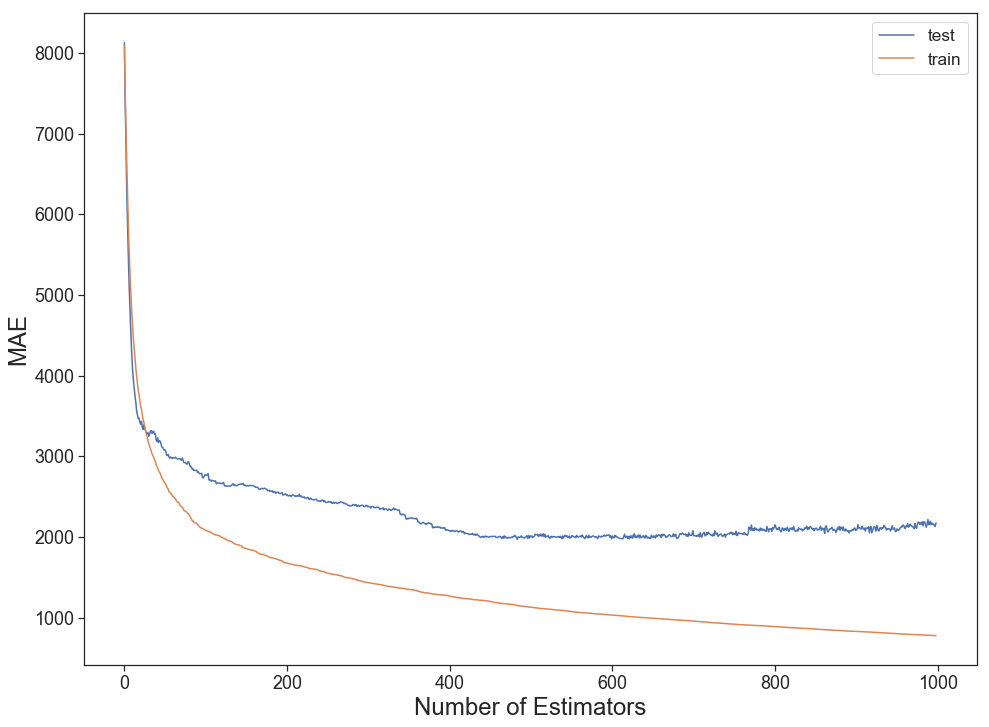

In [78]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 24,
         'axes.titlesize':36,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)
plt.plot(mae) 
plt.plot(mae_train)
plt.legend(['test', 'train'], loc='upper right')
plt.ylabel('MAE',fontsize=24)
plt.xlabel('Number of Estimators',fontsize=24)

Text(0.5,0,'Number of Estimators')

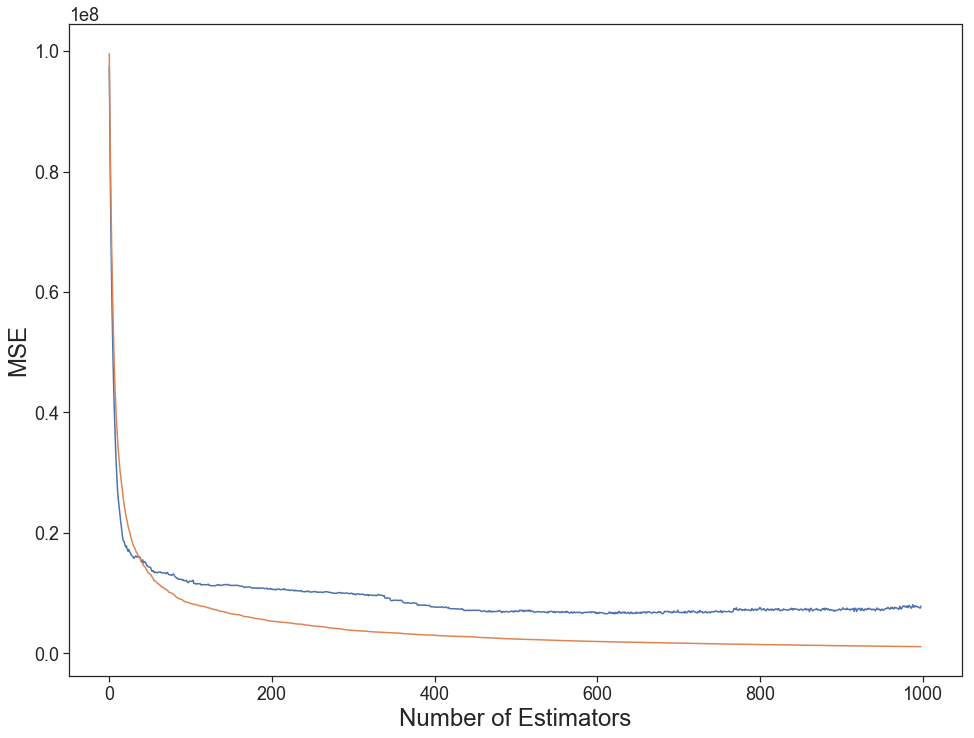

In [79]:
plt.plot(mse)
plt.plot(mse_train)
plt.ylabel('MSE',fontsize=24)
plt.xlabel('Number of Estimators',fontsize=24)

We can see how increasing the both the estimators and the max depth, we get a better approximation of y but we can start to make the model somewhat prone to overfitting.
Therefore it is imperative to make sure we are using validation splits/cross-validation to make sure we are not overfitting our Gradient Boosting models.